<a href="https://colab.research.google.com/github/bmcs-ux/YouTube/blob/main/VARX_REGRESION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [295]:
!pip install fredapi
!pip install arch

In [296]:
# cell_id: ueDnerbGuoPP
#@title Granger Causality and Signal Generation
# forex_multitf_granger.py
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
from scipy.signal import argrelextrema
import warnings
from fredapi import Fred
warnings.filterwarnings("ignore")

In [297]:
# cell_id: uhNywmy65k_k
# ============================================================
# ⚙️ Persiapan Dasar
# ============================================================


import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

plt.style.use("seaborn-v0_8-darkgrid")

In [298]:
# cell_id: JGemPprTvBcw
# --------------------------------
# PARAMETERS (ubah sesuai kebutuhan)
# --------------------------------
PAIRS = {
    "EUR/USD": "EURUSD=X",
    "GBP/USD": "GBPUSD=X",
    "USD/CHF": "USDCHF=X",
    "USD/JPY": "JPY=X",
    "AUD/USD": "AUDUSD=X",
    "XAU/USD": "GC=F",
    "BTC/USD": "BTC-USD",
}

# Data window & base interval to download
lookback_days = 50           # rentang data historis (hari)
base_interval = "4H"         # ambil data base: '1m','2m','5m','15m','30m','60m','90m' (sesuaikan)
# Timeframes we will analyse (mapping ke faktor resample)
TF_MAP = {
    "M1": "1min",
    "M5": "5min",
    "M15": "15min",
    "H1": "60min",
    "H4": "240min"   # will be created by resampling the base data
}
# Note: yfinance intervals use strings like '1m','5m','15m','60m'. We will resample using pandas offsets.

# Granger params
maxlag_test = 12             # max lag (jumlah observation lag) untuk uji Granger
alpha = 0.05                 # signifikansi Granger
min_obs_for_granger = 50     # minimal observasi supaya Granger bermakna

# Prediction params
accum_window = 18             # untuk rolling sum of log returns (dalam unit base interval)
min_events_for_effective_time = 3   # minimal jumlah kejadian agar rata2 waktu efektif bisa dihitung

# Technical params
ma_short = 10
ma_long = 30
slope_window = 5

# Support/Resistance detection
sr_local_window = 12          # window untuk mencari local extrema (nilai ini dalam bars pada timeframe tsb)
pivot_lookback = 30          # untuk menghitung pivot points (high/low/close over last N bars)

# P&L / order params
RR = 2.0                    # TakeProfit : StopLoss ratio

# Output files
OUTPUT_CSV = "granger_forecasts_multitf.csv"

In [299]:
# cell_id: HYcYVva61v1i
#id series_parameter
FRED_SERIES = {
    #"USD_Inflation": "CPIAUCSL",     # CPI AS (index, bisa dipakai hitung inflasi YoY)
    #"Fed_Funds_Rate": "FEDFUNDS",    # Federal Funds Rate
    #"10Y_Yield": "GS10",              # 10-year Treasury yield
    #"Lewis-Mertens-Stock": "WEI",
    "Index Semi-Annual" :  "BAMLH0A0HYM2SYTW",
    "Emerging Markets Corporate": "BAMLEM5BCOCRPISYTW",
    "Markets Corporate Plus" : "BAMLEMRECRPIEMEASYTW",
    "Financial US Emerging Markets Liquiq" : "BAMLEMFLFLCRPIUSSYTW",
}

FRED_API_KEY = "987d18495a386165f0be970f8a733562"


In [300]:
# cell_id: TMxoZtryorwm
#id_series_search
fred.search('Daily frequency').T

series id,WEI,BAMLH0A0HYM2SYTW,BAMLH0A2HYBSYTW,BAMLH0A1HYBBSYTW,BAMLH0A3HYCSYTW,BAMLHE00EHYISYTW,BAMLC0A4CBBBSYTW,BAMLC0A0CMSYTW,BAMLC0A1CAAASYTW,BAMLC0A3CASYTW,...,BAMLEMPBPUBSICRPISYTW,BAMLEM5BCOCRPISYTW,BAMLEMHYHYLCRPIUSSYTW,BAMLEMLLLCRPILAUSSYTW,BAMLEMPTPRVICRPISYTW,BAMLEMNFNFLCRPIUSSYTW,BAMLEM4RBLLCRPIUSSYTW,BAMLEMFLFLCRPIUSSYTW,BAMLEMXOCOLCRPIUSSYTW,BAMLEMNSNFCRPISYTW
id,WEI,BAMLH0A0HYM2SYTW,BAMLH0A2HYBSYTW,BAMLH0A1HYBBSYTW,BAMLH0A3HYCSYTW,BAMLHE00EHYISYTW,BAMLC0A4CBBBSYTW,BAMLC0A0CMSYTW,BAMLC0A1CAAASYTW,BAMLC0A3CASYTW,...,BAMLEMPBPUBSICRPISYTW,BAMLEM5BCOCRPISYTW,BAMLEMHYHYLCRPIUSSYTW,BAMLEMLLLCRPILAUSSYTW,BAMLEMPTPRVICRPISYTW,BAMLEMNFNFLCRPIUSSYTW,BAMLEM4RBLLCRPIUSSYTW,BAMLEMFLFLCRPIUSSYTW,BAMLEMXOCOLCRPIUSSYTW,BAMLEMNSNFCRPISYTW
realtime_start,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,...,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00
realtime_end,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,...,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00,2025-10-21 00:00:00
title,Weekly Economic Index (Lewis-Mertens-Stock),ICE BofA US High Yield Index Semi-Annual Yield...,ICE BofA Single-B US High Yield Index Semi-Ann...,ICE BofA BB US High Yield Index Semi-Annual Yi...,ICE BofA CCC & Lower US High Yield Index Semi-...,ICE BofA Euro High Yield Index Semi-Annual Yie...,ICE BofA BBB US Corporate Index Semi-Annual Yi...,ICE BofA US Corporate Index Semi-Annual Yield ...,ICE BofA AAA US Corporate Index Semi-Annual Yi...,ICE BofA Single-A US Corporate Index Semi-Annu...,...,ICE BofA Public Sector Issuers Emerging Market...,ICE BofA Crossover Emerging Markets Corporate ...,ICE BofA High Yield US Emerging Markets Liquid...,ICE BofA Latin America US Emerging Markets Liq...,ICE BofA Private Sector Issuers Emerging Marke...,ICE BofA Non-Financial US Emerging Markets Liq...,ICE BofA B & Lower US Emerging Markets Liquid ...,ICE BofA Financial US Emerging Markets Liquid ...,ICE BofA Crossover US Emerging Markets Liquid ...,ICE BofA Non-Financial Emerging Markets Corpor...
observation_start,2008-01-05 00:00:00,1996-12-31 00:00:00,1996-12-31 00:00:00,1996-12-31 00:00:00,1996-12-31 00:00:00,1997-12-31 00:00:00,1996-12-31 00:00:00,1996-12-31 00:00:00,1996-12-31 00:00:00,1996-12-31 00:00:00,...,1998-12-31 00:00:00,1998-12-31 00:00:00,2003-12-31 00:00:00,2003-12-31 00:00:00,1998-12-31 00:00:00,2003-12-31 00:00:00,2003-12-31 00:00:00,2003-12-31 00:00:00,2003-12-31 00:00:00,1998-12-31 00:00:00
observation_end,2025-10-11 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,...,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00,2025-10-20 00:00:00
frequency,"Weekly, Ending Saturday","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close",...,"Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close","Daily, Close"
frequency_short,W,D,D,D,D,D,D,D,D,D,...,D,D,D,D,D,D,D,D,D,D
units,Index,Percent,Percent,Percent,Percent,Percent,Percent,Percent,Percent,Percent,...,Percent,Percent,Percent,Percent,Percent,Percent,Percent,Percent,Percent,Percent
units_short,Index,

In [301]:
# cell_id: Tfqcq3-eaKbt
# Mengunduh dan menampilkan data untuk setiap series_id dari dictionary FRED_SERIES

print("Mengunduh dan menampilkan data untuk FRED Series:")

if 'FRED_SERIES' in globals() and 'Fred' in globals():
    fred = Fred(api_key=FRED_API_KEY) # Ensure fred object is initialized

    for name, series_id in FRED_SERIES.items():
        print(f"\n--- Mengunduh data untuk: {name} ({series_id}) ---")
        try:
            # Menggunakan get_series karena get_series_all_releases seringkali terlalu besar
            data = fred.get_series(series_id)

            if data is not None and not data.empty:
                print(f"✅ Berhasil mengunduh {len(data)} observasi. Head:")
                display(data.tail())
            else:
                print(f"⚠️ Tidak ada data yang ditemukan untuk {name} ({series_id}).")

        except Exception as e:
            print(f"⚠️ Gagal mengunduh data untuk {name} ({series_id}): {e}")

else:
    print("⚠️ Variabel 'FRED_SERIES' atau objek 'fred' tidak ditemukan. Pastikan sel-sel sebelumnya telah dijalankan.")

Mengunduh dan menampilkan data untuk FRED Series:

--- Mengunduh data untuk: Index Semi-Annual (BAMLH0A0HYM2SYTW) ---
✅ Berhasil mengunduh 7612 observasi. Head:


,0
2025-10-14,6.87
2025-10-15,6.74
2025-10-16,6.75
2025-10-17,6.79
2025-10-20,6.73



--- Mengunduh data untuk: Emerging Markets Corporate (BAMLEM5BCOCRPISYTW) ---
✅ Berhasil mengunduh 7083 observasi. Head:


,0
2025-10-14,5.46
2025-10-15,5.42
2025-10-16,5.40
2025-10-17,5.41
2025-10-20,5.39



--- Mengunduh data untuk: Markets Corporate Plus (BAMLEMRECRPIEMEASYTW) ---
✅ Berhasil mengunduh 7083 observasi. Head:


,0
2025-10-14,5.10
2025-10-15,5.07
2025-10-16,5.05
2025-10-17,5.06
2025-10-20,5.04



--- Mengunduh data untuk: Financial US Emerging Markets Liquiq (BAMLEMFLFLCRPIUSSYTW) ---
✅ Berhasil mengunduh 5762 observasi. Head:


,0
2025-10-14,5.04
2025-10-15,5.02
2025-10-16,4.99
2025-10-17,5.00
2025-10-20,4.99


In [302]:
# cell_id: r2H7WBnEvX_V

#(pandas_freq_from_tf)
def pandas_freq_from_tf(tf):
    """Return a pandas offset alias for given TF key."""
    if tf.endswith("min") or tf.endswith("min"):
        return tf
    mapping = {
        "1min": "1min",
        "5min": "5min",
        "15min": "15min",
        "60min": "60min",
        "240min": "240min"
    }
    return mapping.get(tf, tf)

In [303]:
# cell_id: uxhukrSSvjjM

#(resample_to_tf)
def resample_to_tf(df, target_minutes):
    """Resample base-minute DataFrame (index DatetimeIndex) to timeframe target_minutes (int)."""
    rule = f"{target_minutes}T"
    o = df.resample(rule).agg({"Open":"first","High":"max","Low":"min","Close":"last","Volume":"sum"})
    o.dropna(how="any", inplace=True)
    return o

In [304]:
# cell_id: IJHTxLbZv4SY

#(compute_pivot_levels)
def compute_pivot_levels(series_high, series_low, series_close):
    high = float(series_high.max())
    low = float(series_low.min())
    close = float(series_close.iloc[-1])
    PP = (high + low + close) / 3.0
    R1 = (2 * PP) - low
    S1 = (2 * PP) - high
    R2 = PP + (high - low)
    S2 = PP - (high - low)
    return {"PP":PP,"R1":R1,"S1":S1,"R2":R2,"S2":S2, "High":high, "Low":low, "Close":close}

In [305]:
# cell_id: tJ2ShOZzwON2

#(find_best_granger_lag)
def find_local_sr_levels(price_series, order=3):
    """Return arrays of local support (min) and resistance (max) levels (values)."""
    arr = price_series.values
    if len(arr) < order * 2 + 1:
        return [], []
    # local maxima
    local_max_idx = argrelextrema(arr, np.greater, order=order)[0]
    local_min_idx = argrelextrema(arr, np.less, order=order)[0]
    resistances = list(price_series.iloc[local_max_idx].round(6))
    supports = list(price_series.iloc[local_min_idx].round(6))
    return supports, resistances

In [306]:
# cell_id: cniOsa45wrBI

#(linear_slope)
def linear_slope(arr):
    """Return slope of linear regression for 1D array (last axis as y)."""
    if len(arr) < 2:
        return 0.0
    X = np.arange(len(arr)).reshape(-1,1)
    y = np.array(arr).reshape(-1,1)
    m = LinearRegression().fit(X,y).coef_[0][0]
    return float(m)

1. **Unduh data FRED melalui API**

   * Gunakan `fredapi` dengan daftar ID terstruktur.
   * Ambil metadata rilis (release date, frequency).

2. **Sinkronisasi tanggal rilis (release-based alignment)**

   * Alih-alih forward-fill, buat kolom `release_date` dan `effective_until_next_release`.
   * Merge ke harga berdasarkan tanggal rilis yang *sudah diketahui pasar*.

In [307]:

# cell_id: Q1YkA5Nh1N3z
# ============================================================
# 📦 FRED DATA DOWNLOAD (Final Robust Version)
# ============================================================


fred = Fred(api_key=FRED_API_KEY)
fred_data = []
fred_metadata = []

for name, series_id in FRED_SERIES.items():
    try:
        # 1️⃣ Ambil metadata
        info = fred.get_series_info(series_id)
        meta = {
            "series_name": name,
            "series_id": series_id,
            "title": getattr(info, "title", None),
            "frequency": getattr(info, "frequency", None),
            "units": getattr(info, "units", None),
            "seasonal_adjustment": getattr(info, "seasonal_adjustment", None),
            "last_updated": getattr(info, "last_updated", None),
            "notes": getattr(info, "notes", None),
        }
        fred_metadata.append(meta)

        # 2️⃣ Ambil data dengan realtime releases (jika memungkinkan)
        try:
            df = fred.get_series_all_releases(series_id)
            mode = "all_releases"
        except Exception as e:
            print(f"⚠️ Fallback {name} ({series_id}) ke simple mode: {e}")
            df = fred.get_series(series_id)
            mode = "simple_series"

        if df is None or len(df) == 0:
            print(f"⚠️ Tidak ada data untuk {name} ({series_id})")
            continue

        # 3️⃣ Normalisasi format DataFrame
        if isinstance(df, pd.Series):
            # Simple mode
            df = df.to_frame(name='value')
            df['release_date'] = pd.to_datetime(df.index)
            df['effective_until_next_release'] = pd.NaT
            df['date'] = df['release_date']
        else:
            # Realtime mode
            if 'realtime_start' not in df.columns:
                df['release_date'] = pd.to_datetime(df['date'], errors='coerce')
            else:
                df['release_date'] = pd.to_datetime(df['realtime_start'], errors='coerce')

            if 'realtime_end' in df.columns:
                df['effective_until_next_release'] = pd.to_datetime(df['realtime_end'], errors='coerce')
            else:
                # Buat manual kalau tidak ada
                df = df.sort_values('release_date')
                df['effective_until_next_release'] = df['release_date'].shift(-1)

            if 'date' not in df.columns:
                df['date'] = df['release_date']

            # pastikan value ada
            if 'value' not in df.columns:
                df.rename(columns={df.columns[-1]: 'value'}, inplace=True)

        # 4️⃣ Konversi tipe data dan bersihkan
        for col in ['release_date', 'effective_until_next_release', 'date']:
            df[col] = pd.to_datetime(df[col], errors='coerce').dt.tz_localize("UTC", nonexistent='shift_forward', ambiguous='NaT')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')

        df = df.dropna(subset=['value']).sort_values(['release_date'])
        df = df.drop_duplicates(subset=['release_date'], keep='last')
        df = df.rename(columns={'value': name})

        fred_data.append(df[['release_date', 'effective_until_next_release', 'date', name]])
        print(f"✅ {name}: {len(df)} observasi ({mode}), freq={meta['frequency']}")

    except Exception as e:
        print(f"⚠️ Gagal ambil {name} ({series_id}): {e}")



⚠️ Fallback Index Semi-Annual (BAMLH0A0HYM2SYTW) ke simple mode: Bad Request.  There are 3006 vintage dates in the specified real-time period: 1776-07-04 to 9999-12-31.  This exceeds the maximum number of vintage dates allowed for this file type (2000).
✅ Index Semi-Annual: 7518 observasi (simple_series), freq=Daily, Close
⚠️ Fallback Emerging Markets Corporate (BAMLEM5BCOCRPISYTW) ke simple mode: Bad Request.  There are 3005 vintage dates in the specified real-time period: 1776-07-04 to 9999-12-31.  This exceeds the maximum number of vintage dates allowed for this file type (2000).
✅ Emerging Markets Corporate: 7001 observasi (simple_series), freq=Daily, Close
⚠️ Fallback Markets Corporate Plus (BAMLEMRECRPIEMEASYTW) ke simple mode: Bad Request.  There are 3005 vintage dates in the specified real-time period: 1776-07-04 to 9999-12-31.  This exceeds the maximum number of vintage dates allowed for this file type (2000).
✅ Markets Corporate Plus: 7001 observasi (simple_series), freq=Dail

In [308]:
# cell_id: display_fred_data_variable
# ============================================================
# 📊 Tampilkan Variabel fred_data Setelah Pengunduhan
# ============================================================

print("\n📋 Menampilkan isi variabel 'fred_data' setelah sel Q1YkA5Nh1N3z:")

if 'df_fred' in globals():
    display(df_fred)
else:
    print("⚠️ Variabel 'fred_data' tidak ditemukan.")

print("\n✅ Tampilan variabel fred_data selesai.")


📋 Menampilkan isi variabel 'fred_data' setelah sel Q1YkA5Nh1N3z:


""



✅ Tampilan variabel fred_data selesai.


In [309]:
# cell_id: L2M_XQRn9FeQ
# (fred_df)
# ============================================================
# 🔁 Gabungkan semua seri berdasarkan tanggal rilis (versi kausal & aman)
# ============================================================

if fred_data and isinstance(fred_data, list) and len(fred_data) > 0:
    clean_data = []

    for i, df in enumerate(fred_data):
        if not isinstance(df, pd.DataFrame) or df.empty:
            print(f"⚠️ Seri ke-{i} kosong atau bukan DataFrame — dilewati.")
            continue

        # Pastikan tidak ada duplikasi kolom
        df = df.loc[:, ~df.columns.duplicated()].copy()

        # Pastikan kolom release_date ada
        if "release_date" not in df.columns:
            if "date" in df.columns:
                df = df.rename(columns={"date": "release_date"})
            else:
                print(f"⚠️ Seri ke-{i} tidak memiliki kolom tanggal — dilewati.")
                continue

        # Tambahkan kolom batas efektif
        if "effective_until_next_release" not in df.columns:
            df = df.sort_values("release_date")
            df["effective_until_next_release"] = df["release_date"].shift(-1)
            df["effective_until_next_release"].fillna(
                df["release_date"].max() + pd.Timedelta(days=7), inplace=True
            )

        # Pilih hanya kolom penting: release_date, effective_until_next_release, dan value
        value_cols = [c for c in df.columns if c not in ["release_date", "effective_until_next_release", "date"]]
        if len(value_cols) == 0:
            print(f"⚠️ Seri ke-{i} tidak memiliki kolom nilai — dilewati.")
            continue

        value_col = value_cols[0]
        df = df[["release_date", "effective_until_next_release", value_col]]
        clean_data.append(df.rename(columns={value_col: f"series_{i}"}))

    if not clean_data:
        fred_df = pd.DataFrame()
        print("⚠️ Tidak ada seri valid untuk digabungkan.")
    else:
        # Mulai dengan seri pertama
        fred_df = clean_data[0].copy()

        # Gabungkan seri lainnya secara asof (berdasarkan release_date)
        for subdf in clean_data[1:]:
            fred_df = pd.merge_asof(
                fred_df.sort_values("release_date"),
                subdf.sort_values("release_date"),
                on="release_date",
                direction="backward",
                suffixes=("", "_dup")
            )
            # Hapus duplikat kolom hasil merge
            dup_cols = [c for c in fred_df.columns if c.endswith("_dup")]
            if dup_cols:
                fred_df.drop(columns=dup_cols, inplace=True)

        # Pastikan tidak ada kolom duplikat
        fred_df = fred_df.loc[:, ~fred_df.columns.duplicated()]

        # Sortir dan reset index
        fred_df = fred_df.sort_values("release_date").reset_index(drop=True)

        # Pastikan timezone aman
        fred_df["release_date"] = pd.to_datetime(fred_df["release_date"], errors="coerce")
        fred_df["effective_until_next_release"] = pd.to_datetime(
            fred_df["effective_until_next_release"], errors="coerce"
        )

        # Rapikan nilai NaN pada series (jika ada, isi dengan last known)
        value_cols = [c for c in fred_df.columns if c.startswith("series_")]
        fred_df[value_cols] = fred_df[value_cols].ffill()

        print(f"\n📊 Total gabungan FRED data: {fred_df.shape}")
        print(f"📅 Periode: {fred_df['release_date'].min().date()} → {fred_df['release_date'].max().date()}")
        print(f"🕒 Kolom efektif: release_date, effective_until_next_release ({len(value_cols)} seri)")
        display(fred_df.head())
        display(fred_df.tail())

else:
    fred_df = pd.DataFrame()
    print("⚠️ Tidak ada data FRED yang valid dari langkah pengunduhan.")

# --- Pastikan index fred_df adalah datetime index valid ---
if not isinstance(fred_df.index, pd.DatetimeIndex):
    # Coba cari kolom tanggal rilis dari FRED API
    if "release_date" in fred_df.columns:
        fred_df["release_date"] = pd.to_datetime(fred_df["release_date"], errors="coerce", utc=True)
        fred_df.set_index("release_date", inplace=True)
    elif "date" in fred_df.columns:
        fred_df["date"] = pd.to_datetime(fred_df["date"], errors="coerce", utc=True)
        fred_df.set_index("date", inplace=True)
    else:
        # fallback jika tidak ada kolom tanggal
        fred_df.index = pd.to_datetime(fred_df.index, errors="coerce", utc=True)

# Drop baris invalid (NaT)
fred_df = fred_df[~fred_df.index.isna()]

# Pastikan timezone UTC
if fred_df.index.tz is None:
    fred_df = fred_df.tz_localize("UTC", nonexistent='shift_forward', ambiguous='NaT')

# --- Rename kolom FRED agar sesuai ID-nya ---
# Find the columns that are value columns (likely starting with 'series_')
value_cols_to_rename = [col for col in fred_df.columns if col.startswith('series_')]
if len(value_cols_to_rename) == len(FRED_SERIES):
    # Create a renaming map from the current series names to the FRED_SERIES keys
    rename_map = {value_cols_to_rename[i]: list(FRED_SERIES.keys())[i] for i in range(len(FRED_SERIES))}
    fred_df.rename(columns=rename_map, inplace=True)
    print("✅ Kolom FRED berhasil di-rename.")
elif len(value_cols_to_rename) < len(FRED_SERIES):
    print(f"⚠️ Jumlah kolom FRED yang terdeteksi ({len(value_cols_to_rename)}) lebih sedikit dari jumlah series di FRED_SERIES ({len(FRED_SERIES)}). Cek urutan merge atau data.")
    # Attempt to rename based on the detected value columns
    rename_map = {value_cols_to_rename[i]: list(FRED_SERIES.keys())[i] for i in range(len(value_cols_to_rename))}
    fred_df.rename(columns=rename_map, inplace=True)
    print(f"ℹ️ Kolom yang terdeteksi ({value_cols_to_rename}) telah di-rename.")

else:
     print(f"⚠️ Jumlah kolom FRED yang terdeteksi ({len(value_cols_to_rename)}) lebih banyak dari jumlah series di FRED_SERIES ({len(FRED_SERIES)}). Cek urutan merge atau data.")


print("\n📊 FRED data final setelah koreksi index dan rename kolom:")
display(fred_df.head())
display(fred_df.tail())


📊 Total gabungan FRED data: (7518, 6)
📅 Periode: 1996-12-31 → 2025-10-20
🕒 Kolom efektif: release_date, effective_until_next_release (4 seri)


,release_date,effective_until_next_release,series_0,series_1,series_2,series_3
0,1996-12-31 00:00:00+00:00,NaT,9.39,NaN,NaN,NaN
1,1997-01-02 00:00:00+00:00,NaT,9.42,NaN,NaN,NaN
2,1997-01-03 00:00:00+00:00,NaT,9.43,NaN,NaN,NaN
3,1997-01-06 00:00:00+00:00,NaT,9.46,NaN,NaN,NaN
4,1997-01-07 00:00:00+00:00,NaT,9.49,NaN,NaN,NaN


,release_date,effective_until_next_release,series_0,series_1,series_2,series_3
7513,2025-10-14 00:00:00+00:00,NaT,6.87,5.46,5.10,5.04
7514,2025-10-15 00:00:00+00:00,NaT,6.74,5.42,5.07,5.02
7515,2025-10-16 00:00:00+00:00,NaT,6.75,5.40,5.05,4.99
7516,2025-10-17 00:00:00+00:00,NaT,6.79,5.41,5.06,5.00
7517,2025-10-20 00:00:00+00:00,NaT,6.73,5.39,5.04,4.99


✅ Kolom FRED berhasil di-rename.

📊 FRED data final setelah koreksi index dan rename kolom:


,effective_until_next_release,Index Semi-Annual,Emerging Markets Corporate,Markets Corporate Plus,Financial US Emerging Markets Liquiq
release_date,,,,,
1996-12-31 00:00:00+00:00,NaT,9.39,NaN,NaN,NaN
1997-01-02 00:00:00+00:00,NaT,9.42,NaN,NaN,NaN
1997-01-03 00:00:00+00:00,NaT,9.43,NaN,NaN,NaN
1997-01-06 00:00:00+00:00,NaT,9.46,NaN,NaN,NaN
1997-01-07 00:00:00+00:00,NaT,9.49,NaN,NaN,NaN


,effective_until_next_release,Index Semi-Annual,Emerging Markets Corporate,Markets Corporate Plus,Financial US Emerging Markets Liquiq
release_date,,,,,
2025-10-14 00:00:00+00:00,NaT,6.87,5.46,5.10,5.04
2025-10-15 00:00:00+00:00,NaT,6.74,5.42,5.07,5.02
2025-10-16 00:00:00+00:00,NaT,6.75,5.40,5.05,4.99
2025-10-17 00:00:00+00:00,NaT,6.79,5.41,5.06,5.00
2025-10-20 00:00:00+00:00,NaT,6.73,5.39,5.04,4.99


In [310]:
print("Data for fred_df:")
display(fred_df.tail())

Data for fred_df:


,effective_until_next_release,Index Semi-Annual,Emerging Markets Corporate,Markets Corporate Plus,Financial US Emerging Markets Liquiq
release_date,,,,,
2025-10-14 00:00:00+00:00,NaT,6.87,5.46,5.10,5.04
2025-10-15 00:00:00+00:00,NaT,6.74,5.42,5.07,5.02
2025-10-16 00:00:00+00:00,NaT,6.75,5.40,5.05,4.99
2025-10-17 00:00:00+00:00,NaT,6.79,5.41,5.06,5.00
2025-10-20 00:00:00+00:00,NaT,6.73,5.39,5.04,4.99


3. **Unduh data harga dari Yahoo Finance**

   * Gunakan `yfinance` untuk `forex`, `commodity`, `crypto`.
   * Periksa timezone dan ubah ke UTC.
   * Resample ke frekuensi harian atau mingguan agar sebanding dengan data makro.

In [311]:
# cell_id: uF4WSh9lxqo2
# --------------------------------
# MAIN: load data for all pairs (base_dfs)
# --------------------------------
print("🔁 Mengunduh data base untuk semua pair...")
base_dfs = {}

for name, sym in PAIRS.items():
    df_base = download_base_symbol(sym, lookback_days, base_interval)
    if df_base is None or df_base.empty:
        print(f"⚠️ Data kosong untuk {name} ({sym}). Coba ubah base_interval atau lookback_days.")
        continue

    # Flatten MultiIndex columns (kalau ada)
    if isinstance(df_base.columns, pd.MultiIndex):
        df_base.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_base.columns]
        ohlcv_cols = {}
        for col in df_base.columns:
            if "Open" in col:
                ohlcv_cols[col] = "Open"
            elif "High" in col:
                ohlcv_cols[col] = "High"
            elif "Low" in col:
                ohlcv_cols[col] = "Low"
            elif "Close" in col:
                ohlcv_cols[col] = "Close"
            elif "Volume" in col:
                ohlcv_cols[col] = "Volume"
        df_base = df_base[list(ohlcv_cols.keys())].rename(columns=ohlcv_cols)

    # ===============================================================
    # Sinkronisasi waktu dengan data FRED terdekat
    # ===============================================================
    if fred_df is not None and not fred_df.empty:
        try:
            # --- Pastikan FRED index tz-aware ---
            fred_index = fred_df.index
            base_tz = getattr(df_base.index, "tzinfo", None)

            # Jika FRED index tidak punya timezone
            if fred_index.tz is None:
                try:
                    # Fallback versi lama pandas tanpa argumen errors
                    fred_index = fred_index.tz_localize(base_tz if base_tz else "UTC")
                except Exception:
                    # Jika gagal lokalize (misal sudah aware)
                    fred_index = fred_index.tz_convert(base_tz) if base_tz else fred_index.tz_convert("UTC")
            else:
                # Jika sudah aware tapi berbeda
                if base_tz and fred_index.tz != base_tz:
                    fred_index = fred_index.tz_convert(base_tz)

            # Replace index baru
            fred_df_localized = fred_df.copy()
            fred_df_localized.index = fred_index

            # Filter waktu sesuai periode harga
            start_time, end_time = df_base.index.min(), df_base.index.max()
            sub_fred = fred_df_localized.loc[(fred_index >= start_time) & (fred_index <= end_time)].copy()

            if sub_fred.empty:
                print(f"⚠️ Tidak ada data FRED dalam jangkauan waktu {name}.")
                sub_fred = None
            else:
                # Sinkronkan (align) dengan timestamp harga
                sub_fred = sub_fred.reindex(df_base.index, method="ffill")
                # Jika ingin langsung merge, uncomment ini:
                # df_base = df_base.join(sub_fred, how="left")
                # print(f"✅ Data FRED disisipkan ke {name} (tanpa shift).")
        except Exception as e:
            print(f"⚠️ Error during FRED data synchronization for {name}: {e}")
            sub_fred = None
    else:
        print(f"⚠️ Melewati integrasi FRED untuk {name} karena data kosong.")
        sub_fred = None

    base_dfs[name] = df_base
    print(f"  • {name}: {len(df_base)} bars (base interval {base_interval})")

if not base_dfs:
    raise SystemExit("Tidak ada data base yang valid. Periksa koneksi / simbol / parameter.")


🔁 Mengunduh data base untuk semua pair...
  • EUR/USD: 299 bars (base interval 4H)
  • GBP/USD: 299 bars (base interval 4H)
  • USD/CHF: 299 bars (base interval 4H)
  • USD/JPY: 299 bars (base interval 4H)
  • AUD/USD: 299 bars (base interval 4H)
  • XAU/USD: 250 bars (base interval 4H)
  • BTC/USD: 299 bars (base interval 4H)


In [312]:
# Display the contents of the base_dfs dictionary
for pair, df in base_dfs.items():
    print(f"Data for {pair}:")
    display(df.tail())
    print("\n")

Data for EUR/USD:


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-10-21 00:00:00+00:00,1.163738,1.165909,1.163603,1.164687,0
2025-10-21 04:00:00+00:00,1.163603,1.163873,1.162385,1.163738,0
2025-10-21 08:00:00+00:00,1.162115,1.163873,1.161036,1.163603,0
2025-10-21 12:00:00+00:00,1.160766,1.162926,1.160227,1.162115,0
2025-10-21 16:00:00+00:00,1.162656,1.162656,1.160766,1.160766,0




Data for GBP/USD:


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-10-21 00:00:00+00:00,1.339316,1.341616,1.339136,1.340447,0
2025-10-21 04:00:00+00:00,1.339136,1.339387,1.337327,1.339351,0
2025-10-21 08:00:00+00:00,1.338366,1.339746,1.336916,1.339351,0
2025-10-21 12:00:00+00:00,1.337310,1.339405,1.336327,1.338366,0
2025-10-21 16:00:00+00:00,1.339477,1.339477,1.337453,1.337453,0




Data for USD/CHF:


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-10-21 00:00:00+00:00,0.79305,0.79320,0.79139,0.79243,0
2025-10-21 04:00:00+00:00,0.79197,0.79370,0.79179,0.79305,0
2025-10-21 08:00:00+00:00,0.79450,0.79528,0.79177,0.79197,0
2025-10-21 12:00:00+00:00,0.79567,0.79601,0.79394,0.79449,0
2025-10-21 16:00:00+00:00,0.79549,0.79569,0.79450,0.79564,0




Data for USD/JPY:


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-10-21 00:00:00+00:00,151.110992,151.145004,150.462997,150.725006,0
2025-10-21 04:00:00+00:00,151.255997,151.606995,150.856003,151.117996,0
2025-10-21 08:00:00+00:00,151.917007,152.048004,151.056000,151.246994,0
2025-10-21 12:00:00+00:00,151.871002,152.173996,151.449005,151.925995,0
2025-10-21 16:00:00+00:00,151.759995,151.876007,151.645996,151.869003,0




Data for AUD/USD:


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-10-21 00:00:00+00:00,0.650957,0.652656,0.650915,0.651848,0
2025-10-21 04:00:00+00:00,0.649857,0.651211,0.648929,0.650999,0
2025-10-21 08:00:00+00:00,0.649014,0.649730,0.648046,0.649730,0
2025-10-21 12:00:00+00:00,0.649309,0.649984,0.647752,0.649014,0
2025-10-21 16:00:00+00:00,0.650449,0.650449,0.649266,0.649266,0




Data for XAU/USD:


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-10-20 16:00:00+00:00,4377.299805,4396.500000,4363.700195,4394.399902,19793
2025-10-20 20:00:00+00:00,4362.899902,4390.000000,4348.399902,4377.399902,45937
2025-10-21 00:00:00+00:00,4312.799805,4362.799805,4309.299805,4362.799805,50272
2025-10-21 04:00:00+00:00,4266.799805,4316.299805,4257.700195,4312.600098,78454
2025-10-21 08:00:00+00:00,4154.000000,4270.899902,4093.000000,4266.799805,231033




Data for BTC/USD:


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-10-21 00:00:00+00:00,109181.945312,110587.632812,109181.945312,110587.632812,1308925952
2025-10-21 04:00:00+00:00,108122.023438,109155.500000,107545.851562,109155.500000,3412430848
2025-10-21 08:00:00+00:00,108604.484375,108738.203125,107534.750000,108131.343750,913567744
2025-10-21 12:00:00+00:00,113351.039062,113536.023438,108292.515625,108615.484375,21797687296
2025-10-21 16:00:00+00:00,113560.718750,113560.718750,113419.351562,113440.382812,821813248


4. **Normalisasi dan transformasi**

   * Terapkan log-return (`log(price_t / price_{t-1})`) untuk harga.
   * Lakukan differencing atau log transform pada seri FRED agar stasioner.

In [313]:
# cell_id: apply_log_return_to_price
# ============================================================
# 📈 Terapkan Log-Return pada Data Harga
# ============================================================

print("\n📐 Menerapkan transformasi log-return pada data harga...")

log_return_dfs = {}
for pair_name, df_base in base_dfs.items():
    if df_base is not None and not df_base.empty and "Close" in df_base.columns:
        try:
            # Hitung log return
            # log(price_t / price_{t-1}) = log(price_t) - log(price_{t-1})
            df_base['Log_Return'] = np.log(df_base['Close'] / df_base['Close'].shift(1))
            # Drop the first row which will have NaN after shift(1)
            df_log_return = df_base.dropna(subset=['Log_Return'])
            log_return_dfs[pair_name] = df_log_return[['Log_Return']] # Store only the Log_Return column
            print(f"  • {pair_name}: Log-return dihitung ({len(df_log_return)} observasi)")
        except Exception as e:
            print(f"⚠️ Gagal hitung log-return untuk {pair_name}: {e}")
            log_return_dfs[pair_name] = pd.DataFrame() # Store empty DataFrame on failure
    else:
        print(f"⚠️ Data harga tidak valid atau kosong untuk {pair_name}. Melewati log-return.")
        log_return_dfs[pair_name] = pd.DataFrame() # Store empty DataFrame

print("\n✅ Proses log-return selesai.")

# Optional: Display head of one of the log-return dataframes to verify
if log_return_dfs:
    first_pair = list(log_return_dfs.keys())[0]
    if not log_return_dfs[first_pair].empty:
        print(f"\nContoh data Log-Return ({first_pair}):")
        display(log_return_dfs[first_pair].head())
    else:
        print("\nTidak ada data log-return yang berhasil dihitung untuk ditampilkan.")
else:
    print("\nTidak ada data log-return yang berhasil dihitung.")


📐 Menerapkan transformasi log-return pada data harga...
  • EUR/USD: Log-return dihitung (298 observasi)
  • GBP/USD: Log-return dihitung (298 observasi)
  • USD/CHF: Log-return dihitung (298 observasi)
  • USD/JPY: Log-return dihitung (298 observasi)
  • AUD/USD: Log-return dihitung (298 observasi)
  • XAU/USD: Log-return dihitung (249 observasi)
  • BTC/USD: Log-return dihitung (298 observasi)

✅ Proses log-return selesai.

Contoh data Log-Return (EUR/USD):


,Log_Return
Datetime,
2025-08-13 04:00:00+00:00,0.001052
2025-08-13 08:00:00+00:00,0.001990
2025-08-13 12:00:00+00:00,0.000235
2025-08-13 16:00:00+00:00,-0.001640
2025-08-13 20:00:00+00:00,0.000585


In [314]:
# cell_id: transform_fred_data
# ============================================================
# 🔄 Terapkan Transformasi pada Data FRED (Differencing / Log Transform)
# ============================================================

print("\n🔄 Menerapkan transformasi pada data FRED agar stasioner...")

transformed_fred_data = {}

# Helper function to apply transformation
def apply_transformation(series, series_name, freq):
    """Applies differencing or log transform based on series name and frequency."""
    # Simple heuristic: Apply log transform to index-like series, differencing to others
    # Adjust this logic based on actual series characteristics if needed
    if "Index" in series_name or "WEI" in series_name:
        print(f"  • Menerapkan Log Transform pada {series_name}")
        # Add a small constant to handle zero or negative values if necessary
        transformed_series = np.log(series.clip(lower=1e-9))
    else:
        print(f"  • Menerapkan Differencing pada {series_name}")
        transformed_series = series.diff().dropna()

    # Optional: Apply seasonal differencing if frequency is known and applicable
    # For weekly/monthly data, seasonal differencing (e.g., .diff(freq=...)) might be needed
    # if "Weekly" in freq:
    #     transformed_series = transformed_series.diff(periods=52).dropna() # Weekly
    # elif "Monthly" in freq:
    #      transformed_series = transformed_series.diff(periods=12).dropna() # Monthly


    return transformed_series

# Iterate through the downloaded FRED data
# Modified to iterate through the list structure of fred_data
# We need to link the DataFrame back to its series name and metadata
if isinstance(fred_data, list):
    print("ℹ️ Iterating through FRED data (list format)...")
    for i, df_series in enumerate(fred_data):
        # Attempt to get the series name from the DataFrame columns
        # Assuming the value column was renamed to the series name during download
        value_cols = [col for col in df_series.columns if col not in ["release_date", "effective_until_next_release", "date"]]
        if len(value_cols) == 1:
            name = value_cols[0]
            series_id = FRED_SERIES.get(name) # Get series_id from FRED_SERIES dict
        else:
            # Fallback if column name doesn't match FRED_SERIES keys
            # Or if there are multiple value columns unexpectedly
            print(f"⚠️ Could not determine series name for DataFrame at index {i}. Skipping.")
            continue

        if df_series is not None and not df_series.empty and name in df_series.columns:
            try:
                # Get metadata to infer frequency if available
                meta = None
                if series_id:
                     # Find metadata from the list (assuming fred_metadata is populated)
                     if 'fred_metadata' in globals() and isinstance(fred_metadata, list):
                         for m in fred_metadata:
                             if m.get("series_id") == series_id:
                                 meta = m
                                 break
                freq = meta.get("frequency", "Unknown") if meta else "Unknown"


                # Apply transformation to the value column
                transformed_series = apply_transformation(df_series[name], name, freq)

                if transformed_series is not None and not transformed_series.empty:
                     # Create a new DataFrame for the transformed series, keeping index
                     transformed_df = transformed_series.to_frame(name=f"{name}_Transformed")
                     # Keep the effective_until_next_release column if it exists and align indices
                     if "effective_until_next_release" in df_series.columns:
                         # Need to align the effective dates with the transformed series index
                         transformed_df = transformed_df.join(df_series["effective_until_next_release"], how="left")
                         # Fill NaT in effective_until_next_release after differencing if needed
                         transformed_df["effective_until_next_release"].ffill(inplace=True)


                     transformed_fred_data[name] = transformed_df
                     print(f"  • {name}: Transformasi berhasil ({len(transformed_df)} observasi)")

                else:
                     print(f"⚠️ Transformasi menghasilkan data kosong untuk {name}.")
                     transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame

            except Exception as e:
                print(f"⚠️ Gagal menerapkan transformasi untuk {name}: {e}")
                transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame on failure
        else:
            print(f"⚠️ Data FRED tidak valid atau kosong untuk {name}. Melewati transformasi.")
            transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame
elif isinstance(fred_data, dict):
     print("ℹ️ Iterating through FRED data (dictionary format)...")
     # Original logic for dictionary format (if download method changes later)
     for name, df_series in fred_data.items():
        if df_series is not None and not df_series.empty and name in df_series.columns:
            try:
                # Get metadata to infer frequency if available
                series_id = FRED_SERIES.get(name)
                meta = None
                if series_id:
                     # Find metadata from the list (assuming fred_metadata is populated)
                     if 'fred_metadata' in globals() and isinstance(fred_metadata, list):
                         for m in fred_metadata:
                             if m.get("series_id") == series_id:
                                 meta = m
                                 break
                freq = meta.get("frequency", "Unknown") if meta else "Unknown"

                # Apply transformation to the value column
                transformed_series = apply_transformation(df_series[name], name, freq)

                if transformed_series is not None and not transformed_series.empty:
                     # Create a new DataFrame for the transformed series, keeping index
                     transformed_df = transformed_series.to_frame(name=f"{name}_Transformed")
                     # Keep the effective_until_next_release column if it exists and align indices
                     if "effective_until_next_release" in df_series.columns:
                          # Need to align the effective dates with the transformed series index
                         transformed_df = transformed_df.join(df_series["effective_until_next_release"], how="left")
                         # Fill NaT in effective_until_next_release after differencing if needed
                         transformed_df["effective_until_next_release"].ffill(inplace=True)

                     transformed_fred_data[name] = transformed_df
                     print(f"  • {name}: Transformasi berhasil ({len(transformed_df)} observasi)")

                else:
                     print(f"⚠️ Transformasi menghasilkan data kosong untuk {name}.")
                     transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame

            except Exception as e:
                print(f"⚠️ Gagal menerapkan transformasi untuk {name}: {e}")
                transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame on failure
        else:
            print(f"⚠️ Data FRED tidak valid atau kosong untuk {name}. Melewati transformasi.")
            transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame

else:
    print("⚠️ Variabel 'fred_data' bukan list atau dictionary yang diharapkan.")


print("\n✅ Proses transformasi data FRED selesai.")

# Optional: Display head of one of the transformed FRED dataframes to verify
if transformed_fred_data:
    first_series = list(transformed_fred_data.keys())[0]
    if not transformed_fred_data[first_series].empty:
        print(f"\nContoh data FRED yang ditransformasi ({first_series}):")
        display(transformed_fred_data[first_series].head())
    else:
        print("\nTidak ada data FRED yang berhasil ditransformasi untuk ditampilkan.")
else:
    print("\nTidak ada data FRED yang berhasil ditransformasi.")


🔄 Menerapkan transformasi pada data FRED agar stasioner...
ℹ️ Iterating through FRED data (list format)...
  • Menerapkan Log Transform pada Index Semi-Annual
  • Index Semi-Annual: Transformasi berhasil (7518 observasi)
  • Menerapkan Differencing pada Emerging Markets Corporate
  • Emerging Markets Corporate: Transformasi berhasil (7000 observasi)
  • Menerapkan Differencing pada Markets Corporate Plus
  • Markets Corporate Plus: Transformasi berhasil (7000 observasi)
  • Menerapkan Differencing pada Financial US Emerging Markets Liquiq
  • Financial US Emerging Markets Liquiq: Transformasi berhasil (5694 observasi)

✅ Proses transformasi data FRED selesai.

Contoh data FRED yang ditransformasi (Index Semi-Annual):


,Index Semi-Annual_Transformed,effective_until_next_release
1996-12-31,2.239645,NaT
1997-01-02,2.242835,NaT
1997-01-03,2.243896,NaT
1997-01-06,2.247072,NaT
1997-01-07,2.250239,NaT


## **2. Data Quality & Stationarity Check**

### 🎯 Tujuan: Memastikan seluruh seri memenuhi syarat uji Granger dan VARX.

**Langkah:**

1. Uji **stasioneritas** setiap seri dengan **ADF/PP test**.

   * Jika non-stasioner → lakukan differencing atau gunakan model VECM.

2. Uji **kointegrasi antar variabel** (Johansen Test).

   * Jika signifikan → gunakan VECM, bukan VARX.

3. Drop seri dengan banyak missing data (>30%) atau gunakan interpolasi logik.

---

In [315]:
# cell_id: handle_missing_fred_data
# ============================================================
# 🧹 Menangani Missing Data pada Data FRED yang Ditransformasi
# ============================================================

print("\n🧹 Menangani missing data pada data FRED yang ditransformasi...")

cleaned_transformed_fred_data = {}
missing_threshold = 0.30 # Ambang batas missing data (30%)
series_to_drop = []

if transformed_fred_data:
    for series_name, df_transformed in transformed_fred_data.items():
        if df_transformed is not None and not df_transformed.empty:
            # Calculate percentage of missing values in the transformed value column
            transformed_col_name = f"{series_name}_Transformed"
            if transformed_col_name in df_transformed.columns:
                missing_percentage = df_transformed[transformed_col_name].isnull().mean()

                if missing_percentage > missing_threshold:
                    print(f"⚠️ Seri '{series_name}' memiliki {missing_percentage:.2%} missing data, melebihi ambang batas {missing_threshold:.0%}. Menandai untuk dihapus.")
                    series_to_drop.append(series_name)
                else:
                    # Apply interpolation (forward fill) for series not marked for dropping
                    # We apply ffill on the transformed value column
                    df_cleaned = df_transformed.copy()
                    df_cleaned[transformed_col_name] = df_cleaned[transformed_col_name].ffill()
                    # Also forward fill the effective_until_next_release column if it exists
                    if "effective_until_next_release" in df_cleaned.columns:
                         df_cleaned["effective_until_next_release"].ffill(inplace=True)

                    cleaned_transformed_fred_data[series_name] = df_cleaned
                    print(f"  • Seri '{series_name}': Missing data ({missing_percentage:.2%}) diisi dengan forward fill.")
            else:
                 print(f"⚠️ Kolom nilai transformasi '{transformed_col_name}' tidak ditemukan di DataFrame '{series_name}'. Melewati penanganan missing data.")
                 # Keep the original data in case the column name was unexpected
                 cleaned_transformed_fred_data[series_name] = df_transformed.copy()

        else:
            print(f"⚠️ Data FRED yang ditransformasi kosong atau tidak valid untuk '{series_name}'. Melewati penanganan missing data.")
            cleaned_transformed_fred_data[series_name] = pd.DataFrame() # Store empty if original was empty

    # Remove series marked for dropping from the cleaned data dictionary
    for series_name in series_to_drop:
        if series_name in cleaned_transformed_fred_data:
            del cleaned_transformed_fred_data[series_name]
            print(f"🗑️ Seri '{series_name}' dihapus karena missing data.")

else:
    print("ℹ️ Tidak ada data FRED yang ditransformasi untuk ditangani missing datanya.")


print("\n📊 Ringkasan Data FRED Setelah Penanganan Missing Data:")
if cleaned_transformed_fred_data:
    for name, df in cleaned_transformed_fred_data.items():
        if not df.empty:
            transformed_col_name = f"{name}_Transformed"
            if transformed_col_name in df.columns:
                remaining_missing_percentage = df[transformed_col_name].isnull().mean()
                print(f"  • {name}: {len(df)} observasi, {remaining_missing_percentage:.2%} missing data.")
            else:
                print(f"  • {name}: {len(df)} observasi, kolom nilai transformasi tidak ditemukan.")
        else:
            print(f"  • {name}: Data kosong.")
else:
    print("ℹ️ Tidak ada data FRED yang berhasil ditangani missing datanya.")


print("\n✅ Penanganan missing data selesai.")



🧹 Menangani missing data pada data FRED yang ditransformasi...
  • Seri 'Index Semi-Annual': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'Emerging Markets Corporate': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'Markets Corporate Plus': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'Financial US Emerging Markets Liquiq': Missing data (0.00%) diisi dengan forward fill.

📊 Ringkasan Data FRED Setelah Penanganan Missing Data:
  • Index Semi-Annual: 7518 observasi, 0.00% missing data.
  • Emerging Markets Corporate: 7000 observasi, 0.00% missing data.
  • Markets Corporate Plus: 7000 observasi, 0.00% missing data.
  • Financial US Emerging Markets Liquiq: 5694 observasi, 0.00% missing data.

✅ Penanganan missing data selesai.


In [316]:
# cell_id: stationarity_test
# ============================================================
# 📈 Uji Stasioneritas dengan ADF dan PP Test & Otomatis Differencing jika Perlu
# ============================================================

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

print("\n🔬 Melakukan uji stasioneritas (ADF dan PP test) dan differencing jika perlu...")

stationarity_results = []
final_stationarized_fred_data = {} # New dictionary to store the final stationarized FRED data

# Test Price Log Returns (should already be stationary)
print("\n--- Menguji Stasioneritas Log Return Harga ---")
for pair_name, df_log_return in log_return_dfs.items():
    if df_log_return is not None and not df_log_return.empty and 'Log_Return' in df_log_return.columns:
        series = df_log_return['Log_Return'].dropna()
        if len(series) > 10: # Need enough observations for the tests
            try:
                # ADF Test
                adf_result = adfuller(series)
                adf_pvalue = adf_result[1]
                is_adf_stationary = adf_pvalue < alpha # Using the global alpha

                # PP Test
                pp_result = PhillipsPerron(series)
                pp_pvalue = pp_result.pvalue
                is_pp_stationary = pp_pvalue < alpha # Using the global alpha

                stationarity_results.append({
                    "Series": pair_name + " (Log Return)",
                    "Test": "ADF",
                    "PValue": adf_pvalue,
                    "Is_Stationary": is_adf_stationary
                })
                stationarity_results.append({
                    "Series": pair_name + " (Log Return)",
                    "Test": "PP",
                    "PValue": pp_pvalue,
                    "Is_Stationary": is_pp_stationary
                })
                print(f"  • {pair_name} (Log Return): ADF p={adf_pvalue:.4f} ({'Stationary' if is_adf_stationary else 'Non-Stationary'}), PP p={pp_pvalue:.4f} ({'Stationary' if is_pp_stationary else 'Non-Stationary'})")

            except Exception as e:
                print(f"⚠️ Gagal melakukan uji stasioneritas untuk {pair_name} (Log Return): {e}")
        else:
            print(f"ℹ️ Data tidak cukup untuk uji stasioneritas untuk {pair_name} (Log Return).")
    else:
        print(f"⚠️ Data log return tidak valid atau kosong untuk {pair_name}.")


# Test and potentially re-transform FRED Data
print("\n--- Menguji Stasioneritas Data FRED yang Ditransformasi & Differencing Otomatis ---")
if transformed_fred_data:
    for series_name, df_transformed in transformed_fred_data.items():
        transformed_col_name = f"{series_name}_Transformed"
        if df_transformed is not None and not df_transformed.empty and transformed_col_name in df_transformed.columns:
            original_transformed_series = df_transformed[transformed_col_name].dropna()
            current_series = original_transformed_series.copy()
            is_stationary = False
            attempts = 0
            max_attempts = 2 # Try differencing up to 2 times if needed

            series_test_results = []

            while not is_stationary and attempts < max_attempts and len(current_series) > 10:
                prefix = "" if attempts == 0 else f"Differenced (Order {attempts}) "
                print(f"  • Menguji {prefix}{series_name} (Transformed FRED)...")

                try:
                    # ADF Test
                    adf_result = adfuller(current_series)
                    adf_pvalue = adf_result[1]
                    is_adf_stationary = adf_pvalue < alpha

                    # PP Test
                    pp_result = PhillipsPerron(current_series)
                    pp_pvalue = pp_result.pvalue
                    is_pp_stationary = pp_pvalue < alpha

                    is_stationary = is_adf_stationary and is_pp_stationary # Consider stationary if BOTH tests pass

                    series_test_results.append({
                        "Series": f"{series_name} (Transformed FRED){' ' + prefix.strip() if prefix else ''}",
                        "Test": "ADF",
                        "PValue": adf_pvalue,
                        "Is_Stationary": is_adf_stationary
                    })
                    series_test_results.append({
                        "Series": f"{series_name} (Transformed FRED){' ' + prefix.strip() if prefix else ''}",
                        "Test": "PP",
                        "PValue": pp_pvalue,
                        "Is_Stationary": is_pp_stationary
                    })

                    print(f"    ADF p={adf_pvalue:.4f} ({'Stationary' if is_adf_stationary else 'Non-Stationary'}), PP p={pp_pvalue:.4f} ({'Stationary' if is_pp_stationary else 'Non-Stationary'})")

                    if not is_stationary and attempts < max_attempts -1:
                         print(f"    -> Tidak stasioner. Menerapkan differencing order {attempts + 1}...")
                         current_series = current_series.diff().dropna()
                         attempts += 1
                    elif not is_stationary and attempts == max_attempts -1:
                        print(f"    -> Masih tidak stasioner setelah {max_attempts} kali differencing.")
                        attempts += 1 # Increment attempts to exit loop

                except Exception as e:
                    print(f"⚠️ Gagal melakukan uji stasioneritas atau differencing untuk {series_name}: {e}")
                    break # Exit while loop on error

            # Add results of all attempts for this series to the main results list
            stationarity_results.extend(series_test_results)

            # Store the final (hopefully stationarized) series
            if is_stationary:
                 final_stationarized_fred_data[series_name] = current_series.to_frame(name=f"{series_name}_FinalTransformed")
                 # Need to re-align effective_until_next_release index if differenced
                 if attempts > 0 and "effective_until_next_release" in df_transformed.columns:
                     # Align effective dates with the index of the differenced series
                     aligned_effective_dates = df_transformed["effective_until_next_release"].reindex(current_series.index, method="ffill")
                     final_stationarized_fred_data[series_name]["effective_until_next_release"] = aligned_effective_dates

            else:
                 print(f"⚠️ {series_name} tetap tidak stasioner setelah {max_attempts} kali differencing. Tidak menyertakan dalam data final.")
                 final_stationarized_fred_data[series_name] = pd.DataFrame() # Store empty if not stationary


        else:
            print(f"⚠️ Data FRED yang ditransformasi awal tidak valid atau kosong untuk {series_name}.")
            final_stationarized_fred_data[series_name] = pd.DataFrame() # Store empty if initial data is bad

else:
    print("\nℹ️ Tidak ada data FRED yang ditransformasi awal untuk diuji.")


# Display results in a DataFrame
stationarity_df = pd.DataFrame(stationarity_results)
if not stationarity_df.empty:
    print("\n📋 Ringkasan Hasil Uji Stasioneritas:")
    # Format PValue for better readability
    stationarity_df['PValue'] = stationarity_df['PValue'].apply(lambda x: f"{x:.4f}")
    display(stationarity_df)
else:
    print("\nℹ️ Tidak ada hasil uji stasioneritas yang tersedia.")

# Display information about final stationarized data
print("\n📊 Data FRED Final Stationer:")
if final_stationarized_fred_data:
    for name, df in final_stationarized_fred_data.items():
        if not df.empty:
            print(f"  • {name}: {len(df)} observasi, kolom: {list(df.columns)}")
            # Optional: display head of the final data
            # display(df.head())
        else:
            print(f"  • {name}: Data kosong (tidak mencapai stasioneritas).")
else:
    print("ℹ️ Tidak ada data FRED yang berhasil distasionerkan.")


print("\n✅ Uji stasioneritas dan differencing otomatis selesai.")



🔬 Melakukan uji stasioneritas (ADF dan PP test) dan differencing jika perlu...

--- Menguji Stasioneritas Log Return Harga ---
  • EUR/USD (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • GBP/USD (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • USD/CHF (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • USD/JPY (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • AUD/USD (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • XAU/USD (Log Return): ADF p=0.0022 (Stationary), PP p=0.0000 (Stationary)
  • BTC/USD (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)

--- Menguji Stasioneritas Data FRED yang Ditransformasi & Differencing Otomatis ---
  • Menguji Index Semi-Annual (Transformed FRED)...
    ADF p=0.1800 (Non-Stationary), PP p=0.2078 (Non-Stationary)
    -> Tidak stasioner. Menerapkan differencing order 1...
  • Menguji Differenced (Order 1) Index Semi-Annual (Transformed F

,Series,Test,PValue,Is_Stationary
0,EUR/USD (Log Return),ADF,0.0000,True
1,EUR/USD (Log Return),PP,0.0000,True
2,GBP/USD (Log Return),ADF,0.0000,True
3,GBP/USD (Log Return),PP,0.0000,True
4,USD/CHF (Log Return),ADF,0.0000,True
5,USD/CHF (Log Return),PP,0.0000,True
6,USD/JPY (Log Return),ADF,0.0000,True
7,USD/JPY (Log Return),PP,0.0000,True
8,AUD/USD (Log Return),ADF,0.0000,True
9,AUD/USD (Log Return),PP,0.0000,True



📊 Data FRED Final Stationer:
  • Index Semi-Annual: 7517 observasi, kolom: ['Index Semi-Annual_FinalTransformed', 'effective_until_next_release']
  • Emerging Markets Corporate: 7000 observasi, kolom: ['Emerging Markets Corporate_FinalTransformed']
  • Markets Corporate Plus: 7000 observasi, kolom: ['Markets Corporate Plus_FinalTransformed']
  • Financial US Emerging Markets Liquiq: 5694 observasi, kolom: ['Financial US Emerging Markets Liquiq_FinalTransformed']

✅ Uji stasioneritas dan differencing otomatis selesai.



📊 Menampilkan dan memvisualisasikan data yang telah ditransformasi dan dibersihkan...

--- Output dari log_return_dfs (Log Return Harga) ---

Log-Return untuk EUR/USD (Head):


,Log_Return
Datetime,
2025-08-13 04:00:00+00:00,0.001052
2025-08-13 08:00:00+00:00,0.001990
2025-08-13 12:00:00+00:00,0.000235
2025-08-13 16:00:00+00:00,-0.001640
2025-08-13 20:00:00+00:00,0.000585



Log-Return untuk EUR/USD (Tail):


,Log_Return
Datetime,
2025-10-21 00:00:00+00:00,-0.001048
2025-10-21 04:00:00+00:00,-0.000116
2025-10-21 08:00:00+00:00,-0.001279
2025-10-21 12:00:00+00:00,-0.001161
2025-10-21 16:00:00+00:00,0.001626


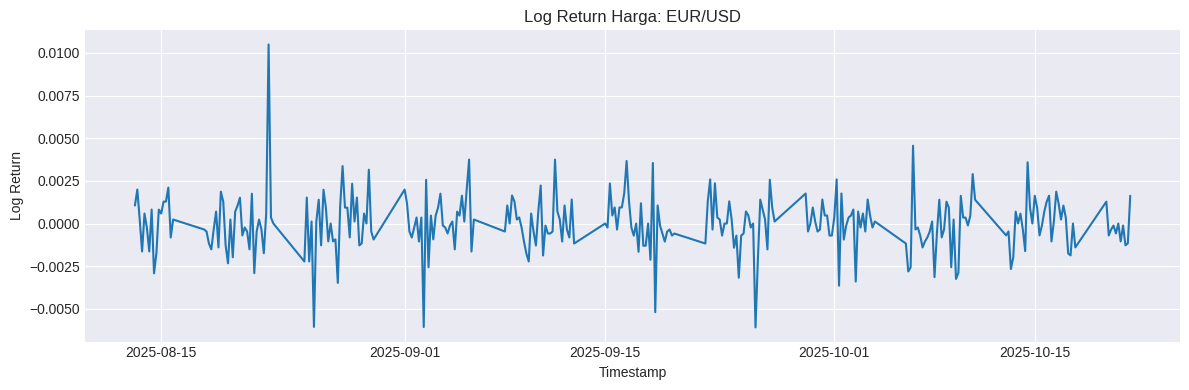


Log-Return untuk GBP/USD (Head):


,Log_Return
Datetime,
2025-08-13 04:00:00+00:00,0.000946
2025-08-13 08:00:00+00:00,0.003941
2025-08-13 12:00:00+00:00,0.000231
2025-08-13 16:00:00+00:00,-0.000421
2025-08-13 20:00:00+00:00,0.000882



Log-Return untuk GBP/USD (Tail):


,Log_Return
Datetime,
2025-10-21 00:00:00+00:00,-0.000844
2025-10-21 04:00:00+00:00,-0.000134
2025-10-21 08:00:00+00:00,-0.000576
2025-10-21 12:00:00+00:00,-0.000789
2025-10-21 16:00:00+00:00,0.001619



Log-Return untuk USD/CHF (Head):


,Log_Return
Datetime,
2025-08-13 04:00:00+00:00,-0.001005
2025-08-13 08:00:00+00:00,-0.002522
2025-08-13 12:00:00+00:00,0.000112
2025-08-13 16:00:00+00:00,0.002075
2025-08-13 20:00:00+00:00,-0.000310



Log-Return untuk USD/CHF (Tail):


,Log_Return
Datetime,
2025-10-21 00:00:00+00:00,0.000820
2025-10-21 04:00:00+00:00,-0.001363
2025-10-21 08:00:00+00:00,0.003189
2025-10-21 12:00:00+00:00,0.001472
2025-10-21 16:00:00+00:00,-0.000226



Log-Return untuk USD/JPY (Head):


,Log_Return
Datetime,
2025-08-13 04:00:00+00:00,-0.001778
2025-08-13 08:00:00+00:00,-0.002520
2025-08-13 12:00:00+00:00,-0.001792
2025-08-13 16:00:00+00:00,0.001942
2025-08-13 20:00:00+00:00,-0.001167



Log-Return untuk USD/JPY (Tail):


,Log_Return
Datetime,
2025-10-21 00:00:00+00:00,0.002438
2025-10-21 04:00:00+00:00,0.000959
2025-10-21 08:00:00+00:00,0.004361
2025-10-21 12:00:00+00:00,-0.000303
2025-10-21 16:00:00+00:00,-0.000731



Log-Return untuk AUD/USD (Head):


,Log_Return
Datetime,
2025-08-13 04:00:00+00:00,0.002216
2025-08-13 08:00:00+00:00,0.001802
2025-08-13 12:00:00+00:00,-0.000400
2025-08-13 16:00:00+00:00,-0.001801
2025-08-13 20:00:00+00:00,0.000838



Log-Return untuk AUD/USD (Tail):


,Log_Return
Datetime,
2025-10-21 00:00:00+00:00,-0.001303
2025-10-21 04:00:00+00:00,-0.001691
2025-10-21 08:00:00+00:00,-0.001299
2025-10-21 12:00:00+00:00,0.000454
2025-10-21 16:00:00+00:00,0.001755



Log-Return untuk XAU/USD (Head):


,Log_Return
Datetime,
2025-08-24 20:00:00+00:00,-0.000674
2025-08-25 00:00:00+00:00,-0.000469
2025-08-25 04:00:00+00:00,0.001377
2025-08-25 08:00:00+00:00,0.000936
2025-08-25 12:00:00+00:00,-0.002431



Log-Return untuk XAU/USD (Tail):


,Log_Return
Datetime,
2025-10-20 16:00:00+00:00,-0.003876
2025-10-20 20:00:00+00:00,-0.003295
2025-10-21 00:00:00+00:00,-0.011550
2025-10-21 04:00:00+00:00,-0.010723
2025-10-21 08:00:00+00:00,-0.026792



Log-Return untuk BTC/USD (Head):


,Log_Return
Datetime,
2025-09-02 04:00:00+00:00,-0.001619
2025-09-02 08:00:00+00:00,-0.004897
2025-09-02 12:00:00+00:00,0.010049
2025-09-02 16:00:00+00:00,-0.000434
2025-09-02 20:00:00+00:00,0.004530



Log-Return untuk BTC/USD (Tail):


,Log_Return
Datetime,
2025-10-21 00:00:00+00:00,-0.012951
2025-10-21 04:00:00+00:00,-0.009755
2025-10-21 08:00:00+00:00,0.004452
2025-10-21 12:00:00+00:00,0.042777
2025-10-21 16:00:00+00:00,0.001848


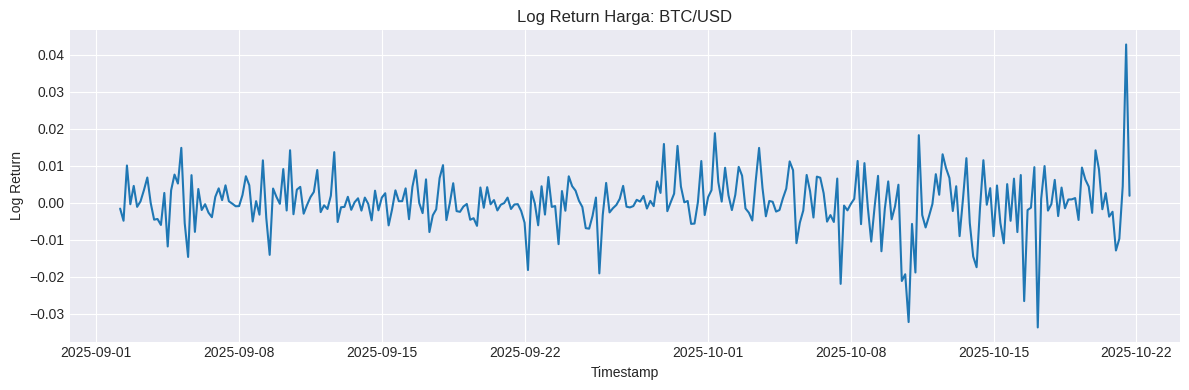


--- Output dari transformed_fred_data (Data FRED Setelah Transformasi Awal) ---

Data FRED yang Ditransformasi Awal untuk Index Semi-Annual (Head):


,Index Semi-Annual_Transformed,effective_until_next_release
1996-12-31,2.239645,NaT
1997-01-02,2.242835,NaT
1997-01-03,2.243896,NaT
1997-01-06,2.247072,NaT
1997-01-07,2.250239,NaT



Data FRED yang Ditransformasi Awal untuk Index Semi-Annual (Tail):


,Index Semi-Annual_Transformed,effective_until_next_release
2025-10-14,1.927164,NaT
2025-10-15,1.908060,NaT
2025-10-16,1.909543,NaT
2025-10-17,1.915451,NaT
2025-10-20,1.906575,NaT


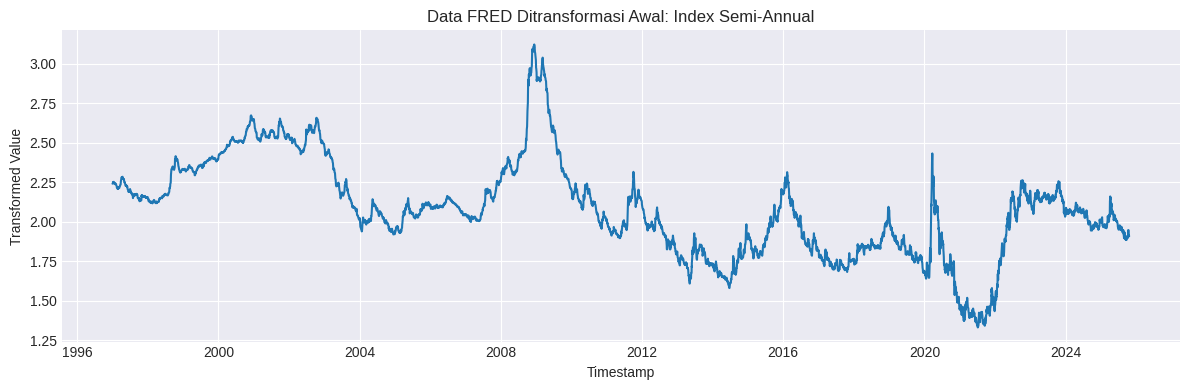


Data FRED yang Ditransformasi Awal untuk Emerging Markets Corporate (Head):


,Emerging Markets Corporate_Transformed,effective_until_next_release
1999-01-04,-0.02,NaT
1999-01-05,-0.02,NaT
1999-01-06,-0.08,NaT
1999-01-07,-0.03,NaT
1999-01-08,0.02,NaT



Data FRED yang Ditransformasi Awal untuk Emerging Markets Corporate (Tail):


,Emerging Markets Corporate_Transformed,effective_until_next_release
2025-10-14,-0.01,NaT
2025-10-15,-0.04,NaT
2025-10-16,-0.02,NaT
2025-10-17,0.01,NaT
2025-10-20,-0.02,NaT



Data FRED yang Ditransformasi Awal untuk Markets Corporate Plus (Head):


,Markets Corporate Plus_Transformed,effective_until_next_release
1999-01-04,0.16,NaT
1999-01-05,0.06,NaT
1999-01-06,-0.04,NaT
1999-01-07,-0.25,NaT
1999-01-08,0.13,NaT



Data FRED yang Ditransformasi Awal untuk Markets Corporate Plus (Tail):


,Markets Corporate Plus_Transformed,effective_until_next_release
2025-10-14,0.01,NaT
2025-10-15,-0.03,NaT
2025-10-16,-0.02,NaT
2025-10-17,0.01,NaT
2025-10-20,-0.02,NaT



Data FRED yang Ditransformasi Awal untuk Financial US Emerging Markets Liquiq (Head):


,Financial US Emerging Markets Liquiq_Transformed,effective_until_next_release
2004-01-02,0.05,NaT
2004-01-05,0.02,NaT
2004-01-06,-0.07,NaT
2004-01-07,-0.02,NaT
2004-01-08,-0.04,NaT



Data FRED yang Ditransformasi Awal untuk Financial US Emerging Markets Liquiq (Tail):


,Financial US Emerging Markets Liquiq_Transformed,effective_until_next_release
2025-10-14,0.02,NaT
2025-10-15,-0.02,NaT
2025-10-16,-0.03,NaT
2025-10-17,0.01,NaT
2025-10-20,-0.01,NaT



--- Output dari stationarity_df (Hasil Uji Stasioneritas) ---

📋 Ringkasan Hasil Uji Stasioneritas:


,Series,Test,PValue,Is_Stationary
0,EUR/USD (Log Return),ADF,0.0000,True
1,EUR/USD (Log Return),PP,0.0000,True
2,GBP/USD (Log Return),ADF,0.0000,True
3,GBP/USD (Log Return),PP,0.0000,True
4,USD/CHF (Log Return),ADF,0.0000,True
5,USD/CHF (Log Return),PP,0.0000,True
6,USD/JPY (Log Return),ADF,0.0000,True
7,USD/JPY (Log Return),PP,0.0000,True
8,AUD/USD (Log Return),ADF,0.0000,True
9,AUD/USD (Log Return),PP,0.0000,True



--- Output dari cleaned_transformed_fred_data (Data FRED Setelah Penanganan Missing Data) ---
⚠️ Variabel 'cleaned_transformed_fred_data' tidak ditemukan atau kosong. Jalankan sel 'handle_missing_fred_data' terlebih dahulu.

✅ Visualisasi dan tampilan data selesai.


In [317]:
# cell_id: visualize_transformed_data
# ============================================================
# 📊 Visualisasi Data yang Ditransformasi dan Dibersihkan
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n📊 Menampilkan dan memvisualisasikan data yang telah ditransformasi dan dibersihkan...")

# --- Output dari log_return_dfs ---
print("\n--- Output dari log_return_dfs (Log Return Harga) ---")
if 'log_return_dfs' in globals() and log_return_dfs:
    for pair_name, df_log_return in log_return_dfs.items():
        if not df_log_return.empty:
            print(f"\nLog-Return untuk {pair_name} (Head):")
            display(df_log_return.head())
            print(f"\nLog-Return untuk {pair_name} (Tail):")
            display(df_log_return.tail())
            # Optional: Plot log returns for a few pairs
            if len(log_return_dfs) <= 3 or pair_name in ['EUR/USD', 'BTC/USD']: # Limit plots to avoid clutter
                 plt.figure(figsize=(12, 4))
                 plt.plot(df_log_return.index, df_log_return['Log_Return'])
                 plt.title(f'Log Return Harga: {pair_name}')
                 plt.ylabel('Log Return')
                 plt.xlabel('Timestamp')
                 plt.tight_layout()
                 plt.show()

        else:
            print(f"ℹ️ log_return_dfs kosong atau belum terisi untuk {pair_name}.")
else:
    print("⚠️ Variabel 'log_return_dfs' tidak ditemukan atau kosong. Jalankan sel 'apply_log_return_to_price' terlebih dahulu.")

# --- Output dari transformed_fred_data (Data FRED Setelah Transformasi Awal) ---
print("\n--- Output dari transformed_fred_data (Data FRED Setelah Transformasi Awal) ---")
# Check if transformed_fred_data exists and is not empty before iterating
if 'transformed_fred_data' in globals() and isinstance(transformed_fred_data, dict) and transformed_fred_data:
    # transformed_fred_data is a dictionary in this cell's logic based on the error
    for series_name, df_transformed in transformed_fred_data.items():
         if not df_transformed.empty:
            print(f"\nData FRED yang Ditransformasi Awal untuk {series_name} (Head):")
            display(df_transformed.head())
            print(f"\nData FRED yang Ditransformasi Awal untuk {series_name} (Tail):")
            display(df_transformed.tail())
            # Optional: Plot transformed FRED data for a few series
            transformed_col_name = f"{series_name}_Transformed"
            if transformed_col_name in df_transformed.columns:
                if len(transformed_fred_data) <= 3 or series_name in ['Index Semi-Annual', 'Lewis-Mertens-Stock']: # Limit plots
                     plt.figure(figsize=(12, 4))
                     plt.plot(df_transformed.index, df_transformed[transformed_col_name])
                     plt.title(f'Data FRED Ditransformasi Awal: {series_name}')
                     plt.ylabel('Transformed Value')
                     plt.xlabel('Timestamp')
                     plt.tight_layout()
                     plt.show()
         else:
             print(f"ℹ️ transformed_fred_data kosong atau belum terisi untuk {series_name}.")
elif 'transformed_fred_data' in globals() and isinstance(transformed_fred_data, pd.DataFrame) and not transformed_fred_data.empty:
     # Fallback check if it's a DataFrame (as it might be in later steps)
     print(f"\nData FRED yang Ditransformasi Awal (DataFrame, Head):")
     display(transformed_fred_data.head())
     print(f"\nData FRED yang Ditransformasi Awal (DataFrame, Tail):")
     display(transformed_fred_data.tail())

else:
    print("⚠️ Variabel 'transformed_fred_data' tidak ditemukan atau kosong. Jalankan sel 'transform_fred_data' terlebih dahulu.")


# --- Output dari stationarity_df (Hasil Uji Stasioneritas) ---
print("\n--- Output dari stationarity_df (Hasil Uji Stasioneritas) ---")
if 'stationarity_df' in globals() and not stationarity_df.empty:
    print("\n📋 Ringkasan Hasil Uji Stasioneritas:")
    display(stationarity_df)
else:
    print("⚠️ Variabel 'stationarity_df' tidak ditemukan atau kosong. Jalankan sel 'stationarity_test' terlebih dahulu.")

# --- Output dari cleaned_transformed_fred_data (Data FRED Setelah Penanganan Missing Data) ---
print("\n--- Output dari cleaned_transformed_fred_data (Data FRED Setelah Penanganan Missing Data) ---")
# Check if cleaned_transformed_fred_data exists and is not empty before iterating
if 'cleaned_transformed_fred_data' in globals() and isinstance(cleaned_transformed_fred_data, pd.DataFrame) and not cleaned_transformed_fred_data.empty:
    # Iterate through the columns if it's a DataFrame (as it should be after cleaning)
    # The previous logic assumed it was a dictionary, which caused the error
    print(f"\nData FRED yang Dibersihkan (DataFrame, Head):")
    display(cleaned_transformed_fred_data.head())
    print(f"\nData FRED yang Dibersihkan (DataFrame, Tail):")
    display(cleaned_transformed_fred_data.tail())

    # Plotting logic for the cleaned DataFrame
    transformed_value_cols = [col for col in cleaned_transformed_fred_data.columns if col.endswith("_Transformed")]
    if transformed_value_cols:
        for transformed_col_name in transformed_value_cols:
            series_name = transformed_col_name.replace("_Transformed", "")
            # Optional: Plot cleaned FRED data for a few series
            if len(transformed_value_cols) <= 3 or series_name in ['Index Semi-Annual', 'Lewis-Mertens-Stock']: # Limit plots
                 plt.figure(figsize=(12, 4))
                 plt.plot(cleaned_transformed_fred_data.index, cleaned_transformed_fred_data[transformed_col_name])
                 plt.title(f'Data FRED Dibersihkan: {series_name}')
                 plt.ylabel('Cleaned Transformed Value')
                 plt.xlabel('Timestamp')
                 plt.tight_layout()
                 plt.show()
    else:
        print("ℹ️ Tidak ada kolom nilai yang ditransformasi untuk diplot di cleaned_transformed_fred_data.")

else:
    print("⚠️ Variabel 'cleaned_transformed_fred_data' tidak ditemukan atau kosong. Jalankan sel 'handle_missing_fred_data' terlebih dahulu.")


print("\n✅ Visualisasi dan tampilan data selesai.")

## **3. Granger Causality Network**

### 🎯 Tujuan: Mengidentifikasi arah dan kekuatan hubungan antar variabel.

**Langkah:**

1. Jalankan uji **bidirectional Granger** antar semua pasangan Makro ↔ Harga.

   * Gunakan `statsmodels.tsa.stattools.grangercausalitytests`.
   * Simpan `p-value` dan `optimal lag`.

2. Buat **peta jaringan kausalitas**:

   * Node = variabel (FRED series / Pair)
   * Edge = arah hubungan signifikan (p < α)
   * Visualisasi dengan `networkx` (Graph of influence).

In [318]:
# cell_id: BV4tSo-lweKq
def find_best_granger_lag(data, cause, effect, maxlag):
    """Return best lag (1..maxlag) that gives smallest p-value for ssr_ftest, plus the p-value.
       data should be a DataFrame with columns [effect, cause].
    """
    best_p = 1.0
    best_lag = None
    for lag in range(1, maxlag+1):
        try:
            res = grangercausalitytests(data[[effect, cause]], maxlag=lag, verbose=False)
            p = res[lag][0]['ssr_ftest'][1]
            if p < best_p:
                best_p = p
                best_lag = lag
        except Exception:
            continue
    return best_lag, best_p

In [319]:

# ============================================================
# 🧩 FIX: Normalisasi dan validasi index + kolom FRED sebelum Granger test
# ============================================================
import pandas as pd

for k, df in list(final_stationarized_fred_data.items()):
    if df is None or df.empty:
        continue

    # --- Pastikan index bertipe datetime ---
    if not isinstance(df.index, pd.DatetimeIndex) or (df.index.min().year < 1980):
        # Coba ambil kolom waktu dari release_date / effective_until_next_release
        time_col = None
        for col in ["effective_until_next_release", "release_date", "date"]:
            if col in df.columns:
                time_col = col
                break
        if time_col:
            df.index = pd.to_datetime(df[time_col], errors="coerce", utc=True)
        else:
            df.index = pd.to_datetime(df.index, errors="coerce", utc=True)
    df = df[~df.index.isna()]

    # --- Pastikan timezone-aware ---
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")

    # --- Drop duplikat index dan sort ---
    df = df[~df.index.duplicated(keep="last")].sort_index()

    # --- Rename kolom dummy series_0..n jadi ID FRED sesuai urutan ---
    if "FRED_SERIES" in globals():
        keys = list(FRED_SERIES.keys())
        rename_map = {}
        for i, col in enumerate(df.columns):
            if col.startswith("series_") and i < len(keys):
                rename_map[col] = keys[i]
        df.rename(columns=rename_map, inplace=True)

    final_stationarized_fred_data[k] = df

In [320]:
# ============================================================
# 🧠 GRANGER TEST: Bidirectional Makro ↔ Pair (Implementasi)
# ============================================================
print("\n🔬 Menjalankan Granger causality (Bidirectional Makro ↔ Pair)...")

# Define the macro series columns to test (use the keys from FRED_SERIES)
# We will use the keys from FRED_SERIES to identify the original series names
# Ensure FRED_SERIES is accessible, assume it is global or defined earlier
if 'FRED_SERIES' not in globals():
    print("⚠️ Variabel FRED_SERIES tidak ditemukan. Tidak dapat melanjutkan uji Granger.")
    macro_granger_df = pd.DataFrame()
else:
    original_macro_series_names = list(FRED_SERIES.keys())

    # Include the function definition here to avoid NameError if it wasn't run before
    def find_best_granger_lag(data, cause, effect, maxlag):
        """Return best lag (1..maxlag) that gives smallest p-value for ssr_ftest, plus the p-value.
           data should be a DataFrame with columns [effect, cause].
        """
        best_p = 1.0
        best_lag = None
        for lag in range(1, maxlag+1):
            try:
                res = grangercausalitytests(data[[effect, cause]], maxlag=lag, verbose=False)
                p = res[lag][0]['ssr_ftest'][1]
                if p < best_p:
                    best_p = p
                    best_lag = lag
            except Exception:
                continue
        return best_lag, best_p


    # Ensure final_stationarized_fred_data is available and not empty before proceeding
    if 'final_stationarized_fred_data' not in globals() or not final_stationarized_fred_data:
        print("⚠️ Data FRED yang distasionerkan (final_stationarized_fred_data) kosong atau tidak ditemukan. Melewati uji Granger.")
        macro_granger_df = pd.DataFrame()
    else:
        # Combine the stationarized FRED data from the dictionary into a single DataFrame
        # Use the index for merging (which should be datetime after stationarity test)
        combined_stationarized_fred_df = pd.DataFrame()
        first_series = True
        for series_name, df_series in final_stationarized_fred_data.items():
            if not df_series.empty:
                # Find the value column (ending with "_FinalTransformed")
                value_cols = [col for col in df_series.columns if col.endswith("_FinalTransformed")]
                if value_cols:
                     value_col = value_cols[0]
                     # Rename the value column to the original series name for clarity
                     # Use the name from FRED_SERIES based on the original series_ index
                     original_name = None
                     try:
                         # Extract the series index from the key (e.g., 'series_0' -> 0)
                         series_index = int(series_name.replace('series_', ''))
                         if series_index < len(original_macro_series_names):
                              original_name = original_macro_series_names[series_index]
                     except (ValueError, IndexError):
                         # Fallback to the series_ name if original name mapping fails
                         original_name = series_name


                     if original_name:
                          df_series = df_series.rename(columns={value_col: original_name})
                          if first_series:
                              # Start with the first non-empty series DataFrame
                              # Keep only the renamed value column and the effective_until_next_release if it exists
                              cols_to_keep = [original_name]
                              if "effective_until_next_release" in df_series.columns:
                                   cols_to_keep.append("effective_until_next_release")
                              combined_stationarized_fred_df = df_series[cols_to_keep].copy()
                              first_series = False
                          else:
                              # Merge subsequent dataframes based on index (datetime)
                              cols_to_merge = [original_name]
                              if "effective_until_next_release" in df_series.columns:
                                   # If effective_until_next_release exists in this series, merge it
                                   # Use combine_first to keep the latest non-null date
                                   if "effective_until_next_release" not in combined_stationarized_fred_df.columns:
                                        combined_stationarized_fred_df["effective_until_next_release"] = df_series["effective_until_next_release"]
                                   else:
                                        combined_stationarized_fred_df["effective_until_next_release"] = combined_stationarized_fred_df["effective_until_next_release"].combine_first(df_series["effective_until_next_release"])

                              combined_stationarized_fred_df = combined_stationarized_fred_df.merge(
                                   df_series[cols_to_merge],
                                   left_index=True,
                                   right_index=True,
                                   how="outer" # Use outer merge to keep all dates
                               )
                     else:
                         print(f"⚠️ Gagal memetakan nama asli untuk seri '{series_name}'. Dilewati penggabungan.")

            else:
                print(f"ℹ️ DataFrame untuk '{series_name}' kosong. Dilewati penggabungan.")


        if combined_stationarized_fred_df.empty:
            print("⚠️ Data FRED yang distasionerkan kosong setelah digabungkan. Melewati uji Granger.")
            macro_granger_df = pd.DataFrame()
        else:
            # Forward fill any NaNs introduced by the outer merge (for value columns)
            # Ensure effective_until_next_release is also forward-filled if it exists
            cols_to_ffill = [col for col in combined_stationarized_fred_df.columns if col != "effective_until_next_release"]
            combined_stationarized_fred_df[cols_to_ffill] = combined_stationarized_fred_df[cols_to_ffill].ffill()
            if "effective_until_next_release" in combined_stationarized_fred_df.columns:
                combined_stationarized_fred_df["effective_until_next_release"] = combined_stationarized_fred_df["effective_until_next_release"].ffill()


            # Ensure index is datetime and timezone-aware (UTC)
            if not isinstance(combined_stationarized_fred_df.index, pd.DatetimeIndex):
                combined_stationarized_fred_df.index = pd.to_datetime(combined_stationarized_fred_df.index, errors="coerce", utc=True)
            if combined_stationarized_fred_df.index.tz is None:
                combined_stationarized_fred_df = combined_stationarized_fred_df.tz_localize("UTC", nonexistent='shift_forward', ambiguous='NaT')


            print(f"✅ Data FRED yang distasionerkan berhasil digabung. Shape: {combined_stationarized_fred_df.shape}")
            display(combined_stationarized_fred_df.head())


            all_granger_results = []

            # Iterate through each pair in base_dfs
            for pair_name, pair_df_base in base_dfs.items():
                print(f"\n🔍 Menguji pair: {pair_name}")
                # Align FRED data with the current pair's base data
                # Ensure both DataFrames have datetime indices and are timezone-aware

                # Ensure pair_df_base index is timezone-aware (should be from download_base_symbol)
                if pair_df_base.index.tzinfo is None:
                     pair_df_base = pair_df_base.tz_localize("UTC", nonexistent='shift_forward', ambiguous='NaT')


                # Select FRED data within the pair's time range and reindex to align
                start_time = pair_df_base.index.min()
                end_time = pair_df_base.index.max()

                # Filter FRED data within the time range, then reindex to align with pair_df_base
                # Need to select only the value columns (excluding effective_until_next_release) before reindexing
                fred_value_cols = [col for col in combined_stationarized_fred_df.columns if col != "effective_until_next_release"]

                if not fred_value_cols:
                     print(f"⚠️ Tidak ada kolom nilai di combined_stationarized_fred_df untuk {pair_name}. Melewati uji Granger.")
                     continue


                sub_fred_values = combined_stationarized_fred_df[fred_value_cols].loc[(combined_stationarized_fred_df.index >= start_time) & (combined_stationarized_fred_df.index <= end_time)].copy()

                if sub_fred_values.empty:
                    print(f"⚠️ Tidak ada data FRED dalam jangkauan waktu {pair_name} setelah filtering. Melewati uji Granger.")
                    continue

                # Reindex the FRED values to the price data index using forward fill
                aligned_fred_values = sub_fred_values.reindex(pair_df_base.index, method="ffill")

                # Drop any macro columns that are all NaN in the aligned data (no data in this period)
                aligned_fred_values.dropna(axis=1, how='all', inplace=True)

                # Ensure the 'Close' column exists in the pair_df_base
                if "Close" not in pair_df_base.columns:
                    print(f"⚠️ Data harga untuk {pair_name} tidak memiliki kolom 'Close'. Melewati uji Granger.")
                    continue

                # Ensure there are valid exogenous columns left after dropping NaNs
                valid_fred_cols = aligned_fred_values.columns.tolist()
                if not valid_fred_cols:
                    print(f"⚠️ Tidak ada kolom FRED valid yang tersisa setelah penanganan NaN untuk {pair_name}. Melewati uji Granger.")
                    continue


                # Combine pair data ("Close") with aligned FRED data
                # Only keep the 'Close' column from the pair data and the selected macro columns from aligned_fred_values
                df_combined_for_granger = pd.concat([pair_df_base[["Close"]], aligned_fred_values[valid_fred_cols]], axis=1).dropna()


                if df_combined_for_granger.empty:
                    print(f"⚠️ Data gabungan kosong setelah dropna untuk {pair_name}. Melewati uji Granger.")
                    continue

                print(f"📊 Data gabungan untuk uji Granger {pair_name}: {df_combined_for_granger.shape}")


                # --- Run Granger test for each macro series against the pair's Close price (Macro -> Pair) ---
                for cause in valid_fred_cols:
                    effect = "Close" # The effect is always the pair's Close price
                    sub_data = df_combined_for_granger[[effect, cause]].dropna()

                    if len(sub_data) < maxlag_test + 2:
                         print(f"ℹ️ Data tidak cukup untuk uji Granger ({cause} → {pair_name}). Min observasi: {maxlag_test + 2}, Tersedia: {len(sub_data)}.")
                         continue

                    try:
                        # Use the find_best_granger_lag function
                        best_lag, best_p = find_best_granger_lag(sub_data, cause, effect, maxlag=maxlag_test)

                        if best_lag is not None and best_p < alpha:
                            all_granger_results.append({
                                "Relation": "Macro -> Pair",
                                "Pair": pair_name,
                                "Cause": cause,
                                "Effect": effect, # Explicitly state effect is "Close"
                                "Best_Lag": best_lag,
                                "PValue": best_p,
                                "Observations": len(sub_data)
                            })
                            print(f"✅ {cause} → {pair_name} (Close): lag={best_lag}, p={best_p:.4f}")
                        # else:
                        #      print(f"ℹ️ {cause} → {pair_name} (Close): p-value > alpha ({alpha}) atau tidak ada lag signifikan. p={best_p:.4f}")

                    except Exception as e:
                        print(f"⚠️ Uji Granger gagal untuk {cause} → {pair_name}: {e}")

                # --- Run Granger test for the pair's Close price against each macro series (Pair -> Macro) ---
                cause = "Close" # The cause is the pair's Close price
                for effect in valid_fred_cols:
                     sub_data = df_combined_for_granger[[effect, cause]].dropna()

                     if len(sub_data) < maxlag_test + 2:
                          print(f"ℹ️ Data tidak cukup untuk uji Granger ({pair_name} → {effect}). Min observasi: {maxlag_test + 2}, Tersedia: {len(sub_data)}.")
                          continue

                     try:
                         # Use the find_best_granger_lag function
                         best_lag, best_p = find_best_granger_lag(sub_data, cause, effect, maxlag=maxlag_test)

                         if best_lag is not None and best_p < alpha:
                             all_granger_results.append({
                                 "Relation": "Pair -> Macro",
                                 "Pair": pair_name,
                                 "Cause": cause, # Explicitly state cause is "Close"
                                 "Effect": effect,
                                 "Best_Lag": best_lag,
                                 "PValue": best_p,
                                 "Observations": len(sub_data)
                             })
                             print(f"✅ {pair_name} (Close) → {effect}: lag={best_lag}, p={best_p:.4f}")
                         # else:
                         #      print(f"ℹ️ {pair_name} (Close) → {effect}: p-value > alpha ({alpha}) atau tidak ada lag signifikan. p={best_p:.4f}")

                     except Exception as e:
                         print(f"⚠️ Uji Granger gagal untuk {pair_name} → {effect}: {e}")

        # Convert results list to DataFrame
        macro_granger_df = pd.DataFrame(all_granger_results)

        if not macro_granger_df.empty:
            print("\n📋 Ringkasan Hasil Uji Granger (Makro ↔ Pair):")
            # Format PValue for better readability
            macro_granger_df['PValue'] = macro_granger_df['PValue'].apply(lambda x: f"{x:.4f}")
            display(macro_granger_df)
            # Optional: Plot the results (e.g., using the plot_macro_granger_results function)
            # plot_macro_granger_results(macro_granger_df[macro_granger_df['Relation'] == 'Macro -> Pair'])
        else:
            print("\nℹ️ Tidak ada hubungan Granger signifikan (Makro ↔ Pair) ditemukan.")


🔬 Menjalankan Granger causality (Bidirectional Makro ↔ Pair)...
✅ Data FRED yang distasionerkan berhasil digabung. Shape: (7519, 5)


,Index Semi-Annual,effective_until_next_release,Emerging Markets Corporate,Markets Corporate Plus,Financial US Emerging Markets Liquiq
1997-01-02 00:00:00+00:00,0.003190,NaT,NaN,NaN,NaN
1997-01-03 00:00:00+00:00,0.001061,NaT,NaN,NaN,NaN
1997-01-06 00:00:00+00:00,0.003176,NaT,NaN,NaN,NaN
1997-01-07 00:00:00+00:00,0.003166,NaT,NaN,NaN,NaN
1997-01-08 00:00:00+00:00,-0.001054,NaT,NaN,NaN,NaN



🔍 Menguji pair: EUR/USD
📊 Data gabungan untuk uji Granger EUR/USD: (299, 5)
✅ Index Semi-Annual → EUR/USD (Close): lag=4, p=0.0002
✅ Emerging Markets Corporate → EUR/USD (Close): lag=10, p=0.0000
✅ Markets Corporate Plus → EUR/USD (Close): lag=4, p=0.0014
✅ Financial US Emerging Markets Liquiq → EUR/USD (Close): lag=4, p=0.0003
✅ EUR/USD (Close) → Emerging Markets Corporate: lag=4, p=0.0109

🔍 Menguji pair: GBP/USD
📊 Data gabungan untuk uji Granger GBP/USD: (299, 5)
✅ Index Semi-Annual → GBP/USD (Close): lag=4, p=0.0000
✅ Emerging Markets Corporate → GBP/USD (Close): lag=10, p=0.0000
✅ Markets Corporate Plus → GBP/USD (Close): lag=4, p=0.0001
✅ Financial US Emerging Markets Liquiq → GBP/USD (Close): lag=4, p=0.0000

🔍 Menguji pair: USD/CHF
📊 Data gabungan untuk uji Granger USD/CHF: (299, 5)
✅ Index Semi-Annual → USD/CHF (Close): lag=1, p=0.0205
✅ Emerging Markets Corporate → USD/CHF (Close): lag=10, p=0.0000
✅ Markets Corporate Plus → USD/CHF (Close): lag=7, p=0.0005
✅ Financial US Em

,Relation,Pair,Cause,Effect,Best_Lag,PValue,Observations
0,Macro -> Pair,EUR/USD,Index Semi-Annual,Close,4,0.0002,299
1,Macro -> Pair,EUR/USD,Emerging Markets Corporate,Close,10,0.0000,299
2,Macro -> Pair,EUR/USD,Markets Corporate Plus,Close,4,0.0014,299
3,Macro -> Pair,EUR/USD,Financial US Emerging Markets Liquiq,Close,4,0.0003,299
4,Pair -> Macro,EUR/USD,Close,Emerging Markets Corporate,4,0.0109,299
5,Macro -> Pair,GBP/USD,Index Semi-Annual,Close,4,0.0000,299
6,Macro -> Pair,GBP/USD,Emerging Markets Corporate,Close,10,0.0000,299
7,Macro -> Pair,GBP/USD,Markets Corporate Plus,Close,4,0.0001,299
8,Macro -> Pair,GBP/USD,Financial US Emerging Markets Liquiq,Close,4,0.0000,299
9,Macro -> Pair,USD/CHF,Index Semi-Annual,Close,1,0.0205,299


In [321]:
print("Rentang waktu data FRED:")
if 'fred_df' in globals() and fred_df is not None and not fred_df.empty:
    print(f"Start: {fred_df.index.min()}")
    print(f"End: {fred_df.index.max()}")
else:
    print("Variabel fred_df tidak ditemukan atau kosong.")

print("\nRentang waktu data harga USD/JPY:")
if 'base_dfs' in globals() and "USD/JPY" in base_dfs and base_dfs["USD/JPY"] is not None and not base_dfs["USD/JPY"].empty:
    print(f"Start: {base_dfs['USD/JPY'].index.min()}")
    print(f"End: {base_dfs['USD/JPY'].index.max()}")
else:
    print("Data harga untuk USD/JPY tidak ditemukan atau kosong.")

Rentang waktu data FRED:
Start: 1996-12-31 00:00:00+00:00
End: 2025-10-20 00:00:00+00:00

Rentang waktu data harga USD/JPY:
Start: 2025-08-13 00:00:00+00:00
End: 2025-10-21 16:00:00+00:00


In [322]:
#cell id : RmpJ8rtUp2YP
# ============================================================
# ✅ Definisi fungsi fit_varx_or_arx() dan visualisasinya
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

def fit_varx_or_arx(df_pair,
                    endog_cols = ["Close"],
                    exog_cols = None,
                    maxlags = 4,
                    criterion = "aic"):
    """
    Fit VARX if endog multivariate, otherwise fit SARIMAX (ARX) for single endog.
    Returns dict with model results and diagnostics.
    """
    result = {"model_type": None, "fitted_model": None, "summary": None, "R2": None, "lags_used": None}

    if exog_cols is None:
        exog_cols = []
    use_cols = list(set(endog_cols + exog_cols))
    sub = df_pair[use_cols].dropna()
    if len(sub) < maxlags + 5:
        raise ValueError(f"Not enough observations: {len(sub)} rows (need > {maxlags+5}).")

    endog = sub[endog_cols]
    exog = sub[exog_cols] if len(exog_cols)>0 else None

    # VARMAX jika multi endog
    if endog.shape[1] > 1:
        best_p = None
        best_ic = np.inf
        for p in range(1, maxlags+1):
            try:
                m = VARMAX(endog, exog=exog, order=(p,0))
                r = m.fit(disp=False, maxiter=200)
                ic = getattr(r, criterion)
                if ic is not None and ic < best_ic:
                    best_ic = ic
                    best_p = p
                    best_res = r
            except Exception:
                continue
        if best_p is None:
            raise RuntimeError("Gagal fitting VARMAX.")
        result["model_type"] = "VARMAX"
        result["fitted_model"] = best_res
        result["summary"] = best_res.summary()
        result["lags_used"] = best_p
        resid = best_res.resid
        r2s = {col: 1 - np.nanvar(resid[col]) / np.nanvar(endog[col]) for col in endog.columns}
        result["R2"] = r2s
        return result

    # SARIMAX jika single endog
    else:
        y = endog.iloc[:,0]
        best_p = None
        best_ic = np.inf
        best_res = None
        for p in range(1, maxlags+1):
            try:
                model = SARIMAX(y, exog=exog, order=(p,0,0),
                                enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit(disp=False, maxiter=200)
                ic = getattr(res, criterion)
                if ic is not None and ic < best_ic:
                    best_ic = ic
                    best_p = p
                    best_res = res
            except Exception:
                continue
        if best_res is None:
            raise RuntimeError("Gagal fitting SARIMAX.")
        result["model_type"] = "SARIMAX(ARX)"
        result["fitted_model"] = best_res
        result["summary"] = best_res.summary()
        result["lags_used"] = best_p
        resid = best_res.resid
        result["R2"] = float(1 - np.nanvar(resid) / np.nanvar(y))
        return result

# ============================================================
# 🔍 Fungsi untuk menampilkan hasil teks
# ============================================================
def print_varx_result_text(res_dict, pair_name):
    print(f"--- VARX/ARX result for {pair_name} ---")
    print("Model type:", res_dict["model_type"])
    print("Lags used:", res_dict["lags_used"])
    print("R2:", res_dict["R2"])
    print("\nModel summary (truncated):")
    print(res_dict["summary"])

# ============================================================
# 📊 Fungsi untuk visualisasi grafik
# ============================================================
def plot_varx_fit_and_resid(df_pair, endog_col="Close", res_dict=None, exog_cols=None):
    if res_dict is None or res_dict["fitted_model"] is None:
        raise ValueError("No fitted model provided.")
    sub = df_pair[[endog_col] + (exog_cols if exog_cols else [])].dropna()
    model = res_dict["fitted_model"]
    try:
        fitted = model.fittedvalues
        fitted = pd.Series(fitted, index=sub.index[:len(fitted)])
    except Exception:
        fitted = model.predict(start=sub.index[0], end=sub.index[-1],
                               exog=sub[exog_cols] if exog_cols else None)
    y = sub[endog_col]
    plt.figure(figsize=(12,4))
    plt.plot(y.index, y.values, label="Actual")
    plt.plot(fitted.index, fitted.values, label="Fitted", alpha=0.8)
    plt.title(f"{endog_col} - actual vs fitted")
    plt.legend()
    plt.tight_layout()
    plt.show()

    resid = model.resid
    plt.figure(figsize=(12,3))
    plt.plot(resid.index if hasattr(resid, "index") else range(len(resid)), resid, label="Residuals")
    plt.axhline(0, color="k", linestyle="--", alpha=0.6)
    plt.title("Residuals")
    plt.tight_layout()
    plt.show()

In [323]:
# cell_id: UtxyIg91I5fv
def plot_varx_macro_results(varx_df):
    plt.figure(figsize=(8, 4))
    sns.barplot(x="Pair", y="R2", data=varx_df, color="skyblue")
    plt.title("VARX Model Fit (Makro → Pair)")
    plt.ylabel("R² (Goodness of Fit)")
    plt.tight_layout()
    plt.show()


📈 Menjalankan model VARX (Makro → Pair)...

🧠 Membangun model VARX untuk pair: EUR/USD
ℹ️ Attempting to fit model for EUR/USD with endog=['Close'] and exog=['Index Semi-Annual', 'Emerging Markets Corporate', 'Markets Corporate Plus', 'Financial US Emerging Markets Liquiq']
✅ Model SARIMAX(ARX) for EUR/USD fitted successfully. R²=-137.4014

🧠 Membangun model VARX untuk pair: GBP/USD
ℹ️ Attempting to fit model for GBP/USD with endog=['Close'] and exog=['Index Semi-Annual', 'Emerging Markets Corporate', 'Markets Corporate Plus', 'Financial US Emerging Markets Liquiq']
✅ Model SARIMAX(ARX) for GBP/USD fitted successfully. R²=-109.0677

🧠 Membangun model VARX untuk pair: USD/CHF
ℹ️ Attempting to fit model for USD/CHF with endog=['Close'] and exog=['Index Semi-Annual', 'Emerging Markets Corporate', 'Markets Corporate Plus', 'Financial US Emerging Markets Liquiq']
✅ Model SARIMAX(ARX) for USD/CHF fitted successfully. R²=-58.9155

🧠 Membangun model VARX untuk pair: USD/JPY
ℹ️ Attempting to fi

,Pair,Model_Type,Lags_Used,R2
0,EUR/USD,SARIMAX(ARX),1,-137.401383
1,GBP/USD,SARIMAX(ARX),1,-109.067719
2,USD/CHF,SARIMAX(ARX),3,-58.915467
3,USD/JPY,SARIMAX(ARX),11,-7.408596
4,AUD/USD,SARIMAX(ARX),1,-42.144650
5,XAU/USD,SARIMAX(ARX),3,-0.175693
6,BTC/USD,SARIMAX(ARX),12,0.922502


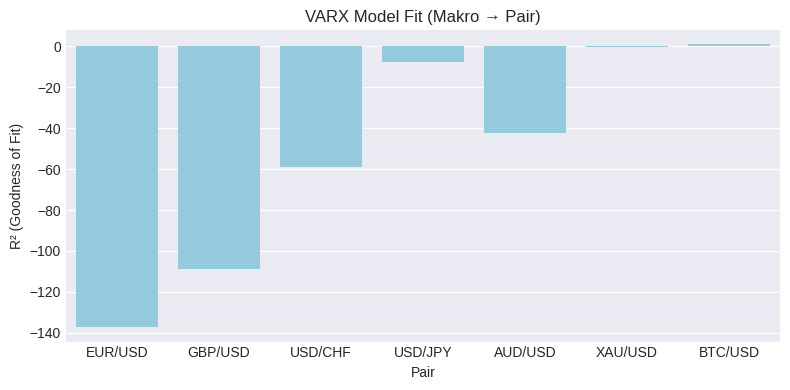

In [324]:
# cell_id: 445c9a16
# ============================================================
# 🧮 VARX: Makro → Pair (Implementasi)
# ============================================================
print("\n📈 Menjalankan model VARX (Makro → Pair)...")

varx_macro_results = []
fitted_models = {} # Store fitted models if needed later

# Define the macro series columns to test (use the keys from FRED_SERIES)
macro_series_cols = list(FRED_SERIES.keys())

# Iterate through each pair in base_dfs
for pair_name, pair_df_base in base_dfs.items():
    print(f"\n🧠 Membangun model VARX untuk pair: {pair_name}")
    # Align FRED data with the current pair's base data
    if fred_df is not None and not fred_df.empty:
        # Select FRED data within the pair's time range and ffill
        start_time = pair_df_base.index.min()
        end_time = pair_df_base.index.max()
        sub_fred = fred_df.loc[(fred_df.index >= start_time) & (fred_df.index <= end_time)].copy()
        sub_fred = sub_fred.reindex(pair_df_base.index, method="ffill")

        # Drop any macro columns that are all NaN in the sub_fred (no data in this period)
        sub_fred.dropna(axis=1, how='all', inplace=True)

        # Ensure only relevant macro columns are selected for exog
        cols_to_join = [col for col in macro_series_cols if col in sub_fred.columns]
        if not cols_to_join:
            print(f"⚠️ Tidak ada data FRED yang relevan untuk {pair_name} dalam rentang waktu ini. Melewati VARX.")
            continue

        # Combine pair data ("Close") with aligned FRED data (exog)
        df_combined_for_varx = pd.concat([pair_df_base[["Close"]], sub_fred[cols_to_join]], axis=1).dropna()

        if df_combined_for_varx.empty:
            print(f"⚠️ Data gabungan kosong after dropna for {pair_name}. Skipping VARX.")
            continue

        try:
            # Use the robust fit_varx_or_arx function
            # Pass the combined dataframe and specify endogenous and exogenous columns
            print(f"ℹ️ Attempting to fit model for {pair_name} with endog=['Close'] and exog={cols_to_join}")
            model_result = fit_varx_or_arx(
                df_pair=df_combined_for_varx,
                endog_cols=["Close"],
                exog_cols=cols_to_join,
                maxlags=maxlag_test # Use maxlag_test from parameters
            )

            varx_macro_results.append({
                "Pair": pair_name,
                "Model_Type": model_result["model_type"],
                "Lags_Used": model_result["lags_used"],
                "R2": model_result["R2"]
            })
            fitted_models[pair_name] = model_result # Store the result dictionary

            print(f"✅ Model {model_result['model_type']} for {pair_name} fitted successfully. R²={model_result['R2']:.4f}")
            # Optional: Print summary and plot fit/residuals for each model
            #print_varx_result_text(model_result, pair_name)
            #plot_varx_fit_and_resid(df_combined_for_varx, endog_col="Close", res_dict=model_result, exog_cols=cols_to_join)


        except Exception as e:
            print(f"⚠️ Model fitting for {pair_name} failed: {e}")
            varx_macro_results.append({"Pair": pair_name, "Model_Type": None, "Lags_Used": None, "R2": np.nan}) # Record NaN for failed fits

    else:
        print(f"⚠️ Tidak ada data FRED yang valid untuk diuji VARX dengan {pair_name}. Melewati VARX.")


varx_macro_df = pd.DataFrame(varx_macro_results)

if not varx_macro_df.empty:
    print("\n📋 Hasil Model VARX/ARX (Makro → Pair) R²:")
    display(varx_macro_df)
    # Optional: Plot the results
    # You might need to adapt plot_varx_macro_results or create a new one
    plot_varx_macro_results(varx_macro_df)
else:
    print("\nℹ️ Tidak ada hasil model VARX/ARX (Makro → Pair).")


In [325]:
# cell_id: save_fitted_models
# ============================================================
# 💾 Menyimpan Model yang Cocok
# ============================================================

import pickle
import os

# Tentukan folder untuk menyimpan model
model_save_dir = "fitted_models"
os.makedirs(model_save_dir, exist_ok=True)

print(f"\n💾 Menyimpan model ke folder: {model_save_dir}")

# Simpan setiap model dalam dictionary fitted_models
saved_models_list = []
for pair_name, model_result in fitted_models.items():
    if model_result and model_result["fitted_model"] is not None:
        model_filename = os.path.join(model_save_dir, f"{pair_name.replace('/', '_')}_ARX_model.pkl")
        try:
            with open(model_filename, 'wb') as f:
                pickle.dump(model_result["fitted_model"], f)
            print(f"✅ Model untuk {pair_name} berhasil disimpan ke {model_filename}")
            saved_models_list.append(pair_name)
        except Exception as e:
            print(f"⚠️ Gagal menyimpan model untuk {pair_name}: {e}")
    else:
        print(f"ℹ️ Model untuk {pair_name} tidak tersedia atau tidak cocok untuk disimpan.")

if saved_models_list:
    print(f"\n✅ Selesai menyimpan model untuk: {', '.join(saved_models_list)}")
else:
    print("\nℹ️ Tidak ada model yang berhasil disimpan.")

# Contoh cara memuat kembali (untuk runtime berikutnya)
# print("\nContoh cara memuat kembali model (untuk runtime berikutnya):")
# loaded_model = None
# try:
#     with open(os.path.join(model_save_dir, "XAU_USD_ARX_model.pkl"), 'rb') as f:
#         loaded_model = pickle.load(f)
#     print("\n✅ Model XAU/USD berhasil dimuat kembali.")
#     # Anda sekarang bisa menggunakan loaded_model untuk prediksi, dll.
#     # print(loaded_model.summary()) # Contoh: tampilkan ringkasan model yang dimuat
# except FileNotFoundError:
#     print(f"⚠️ File model XAU_USD_ARX_model.pkl tidak ditemukan.")
# except Exception as e:
#     print(f"⚠️ Gagal memuat kembali model XAU/USD: {e}")


💾 Menyimpan model ke folder: fitted_models
✅ Model untuk EUR/USD berhasil disimpan ke fitted_models/EUR_USD_ARX_model.pkl
✅ Model untuk GBP/USD berhasil disimpan ke fitted_models/GBP_USD_ARX_model.pkl
✅ Model untuk USD/CHF berhasil disimpan ke fitted_models/USD_CHF_ARX_model.pkl
✅ Model untuk USD/JPY berhasil disimpan ke fitted_models/USD_JPY_ARX_model.pkl
✅ Model untuk AUD/USD berhasil disimpan ke fitted_models/AUD_USD_ARX_model.pkl
✅ Model untuk XAU/USD berhasil disimpan ke fitted_models/XAU_USD_ARX_model.pkl
✅ Model untuk BTC/USD berhasil disimpan ke fitted_models/BTC_USD_ARX_model.pkl

✅ Selesai menyimpan model untuk: EUR/USD, GBP/USD, USD/CHF, USD/JPY, AUD/USD, XAU/USD, BTC/USD


In [326]:
# ============================================================
# 📂 Memuat Kembali Model yang Disimpan
# ============================================================

import pickle
import os

model_save_dir = "fitted_models"
model_filename = os.path.join(model_save_dir, "XAU_USD_ARX_model.pkl")

loaded_xauusd_model = None

try:
    with open(model_filename, 'rb') as f:
        loaded_xauusd_model = pickle.load(f)
    print(f"✅ Model XAU/USD berhasil dimuat kembali dari {model_filename}.")

    # Anda sekarang bisa menggunakan loaded_xauusd_model untuk prediksi atau analisis lebih lanjut
    print("\nRingkasan model yang dimuat:")
    print(loaded_xauusd_model.summary())

except FileNotFoundError:
    print(f"⚠️ File model {model_filename} tidak ditemukan. Pastikan Anda sudah menjalankan sel penyimpanan model terlebih dahulu.")
except Exception as e:
    print(f"⚠️ Gagal memuat kembali model XAU/USD: {e}")

✅ Model XAU/USD berhasil dimuat kembali dari fitted_models/XAU_USD_ARX_model.pkl.

Ringkasan model yang dimuat:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  248
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1176.937
Date:                Tue, 21 Oct 2025   AIC                           2369.873
Time:                        16:08:43   BIC                           2397.883
Sample:                             0   HQIC                          2381.153
                                - 248                                         
Covariance Type:                  opg                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Index Semi-Annual                      126.196


📊 Memvisualisasikan data gabungan dan residual model...

--- Visualisasi untuk EUR/USD ---
Plotting combined data for EUR/USD (Shape: (299, 5))


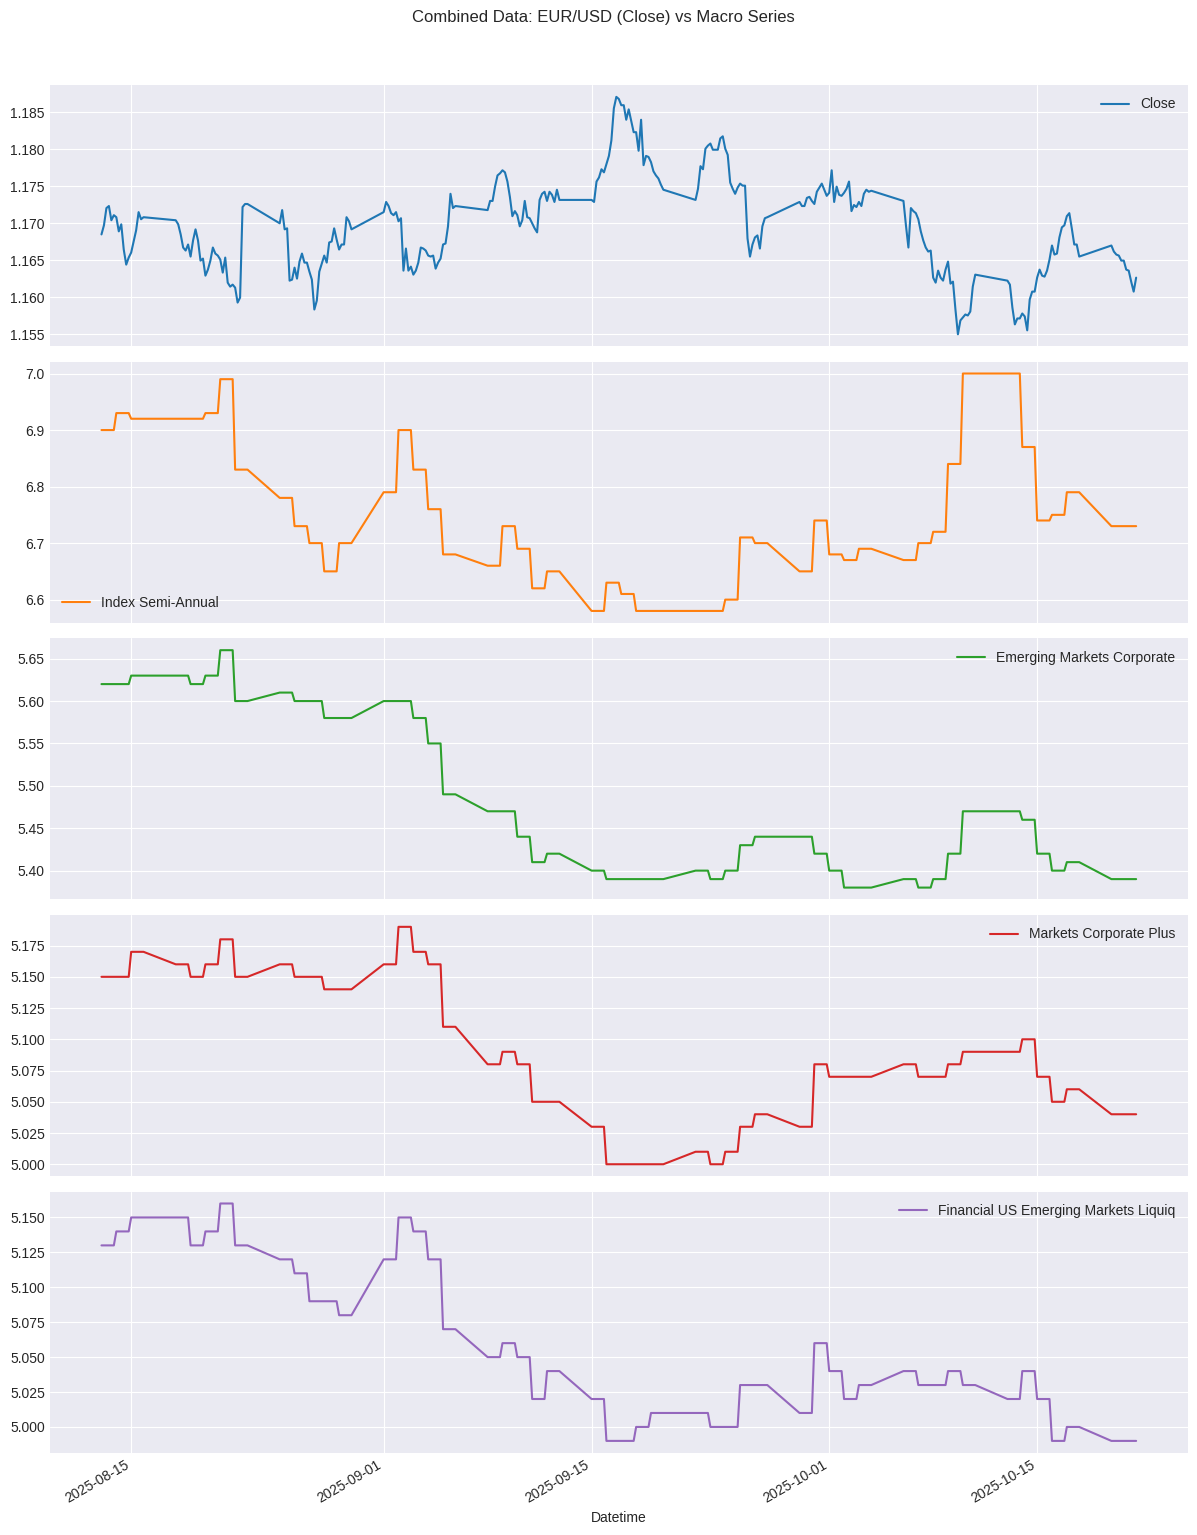

Plotting model fit and residuals for EUR/USD


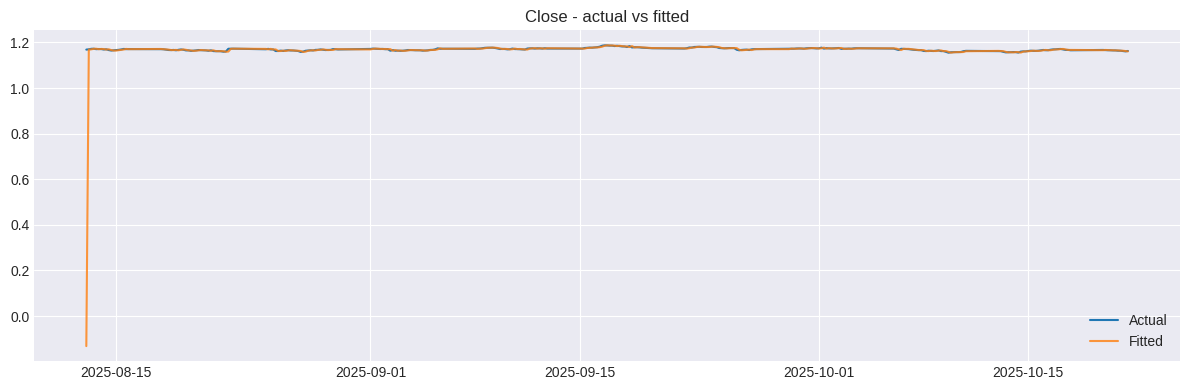

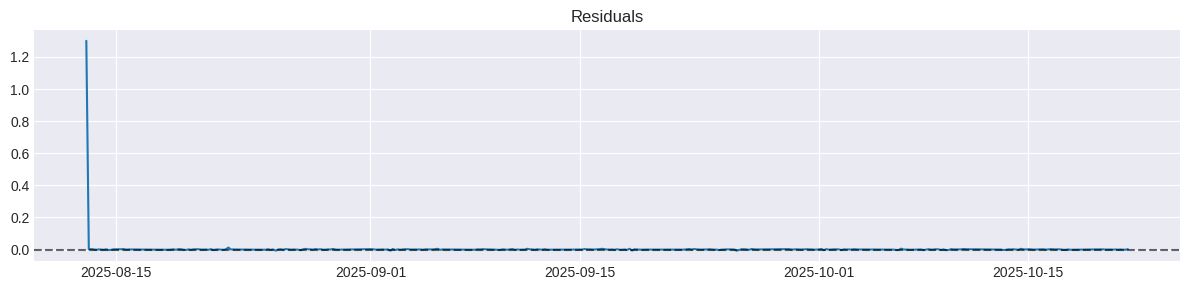


✅ Visualisasi selesai.


In [327]:
# cell_id: generate_cells_2
# ============================================================
# 📊 Visualisasi Data Gabungan dan Residual Model VARX/ARX
# ============================================================

print("\n📊 Memvisualisasikan data gabungan dan residual model...")

# Pilih satu pair dengan R2 negatif untuk visualisasi
pair_to_plot = None
for pair, r2 in varx_macro_df.set_index("Pair")["R2"].items():
    if r2 < 0:
        pair_to_plot = pair
        break

if pair_to_plot and pair_to_plot in fitted_models:
    print(f"\n--- Visualisasi untuk {pair_to_plot} ---")

    # Dapatkan data gabungan yang digunakan untuk model
    # Reconstruct the combined data used for fitting
    pair_df_base = base_dfs.get(pair_to_plot)
    model_result = fitted_models[pair_to_plot]

    if pair_df_base is not None and fred_df is not None:
        start_time = pair_df_base.index.min()
        end_time = pair_df_base.index.max()
        sub_fred = fred_df.loc[(fred_df.index >= start_time) & (fred_df.index <= end_time)].copy()
        sub_fred = sub_fred.reindex(pair_df_base.index, method="ffill")
        sub_fred.dropna(axis=1, how='all', inplace=True) # Drop macro cols with no data

        cols_to_join = [col for col in FRED_SERIES.keys() if col in sub_fred.columns] # Use keys from FRED_SERIES
        if cols_to_join:
             df_combined_for_varx_plot = pd.concat([pair_df_base[["Close"]], sub_fred[cols_to_join]], axis=1).dropna()
        else:
            df_combined_for_varx_plot = pair_df_base[["Close"]].dropna() # Only Close if no macro data


        if not df_combined_for_varx_plot.empty:
            # Plot data gabungan (Close vs Macro)
            print(f"Plotting combined data for {pair_to_plot} (Shape: {df_combined_for_varx_plot.shape})")
            df_combined_for_varx_plot.plot(subplots=True, figsize=(12, len(df_combined_for_varx_plot.columns)*3))
            plt.suptitle(f"Combined Data: {pair_to_plot} (Close) vs Macro Series", y=1.02)
            plt.tight_layout()
            plt.show()

            # Plot actual vs fitted and residuals using the function defined earlier
            try:
                print(f"Plotting model fit and residuals for {pair_to_plot}")
                plot_varx_fit_and_resid(df_combined_for_varx_plot,
                                        endog_col="Close",
                                        res_dict=model_result,
                                        exog_cols=cols_to_join if cols_to_join else None)
            except Exception as e:
                 print(f"⚠️ Gagal plot fit/residuals untuk {pair_to_plot}: {e}")

        else:
            print(f"⚠️ Data gabungan kosong untuk plot {pair_to_plot}. Tidak bisa visualisasi.")
    else:
         print(f"⚠️ Data base atau FRED tidak tersedia untuk plot {pair_to_plot}. Tidak bisa visualisasi.")

else:
    print("\nℹ️ Tidak ada pair dengan R² negatif atau model yang terpasang untuk divisualisasikan.")

print("\n✅ Visualisasi selesai.")

In [328]:
# cell_id: analyze_xauusd_btcbtc_models
# ============================================================
# 📊 Analisis Model VARX/ARX untuk XAU/USD dan BTC/USD
# ============================================================

print("\n🔬 Analisis Model untuk XAU/USD dan BTC/USD...")

pairs_to_analyze = ["XAU/USD", "BTC/USD"]

for pair_name in pairs_to_analyze:
    if pair_name in fitted_models:
        model_result = fitted_models[pair_name]
        print(f"\n--- Ringkasan Model untuk {pair_name} ({model_result['model_type']}) ---")
        print(f"R²: {model_result['R2']:.4f}")
        print(f"Lags Used: {model_result['lags_used']}")
        # Display the model summary
        print(model_result['summary'])
    else:
        print(f"\n⚠️ Model untuk {pair_name} tidak ditemukan dalam fitted_models.")

print("\n✅ Analisis model selesai.")


🔬 Analisis Model untuk XAU/USD dan BTC/USD...

--- Ringkasan Model untuk XAU/USD (SARIMAX(ARX)) ---
R²: -0.1757
Lags Used: 3
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  248
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1176.937
Date:                Tue, 21 Oct 2025   AIC                           2369.873
Time:                        16:08:39   BIC                           2397.883
Sample:                             0   HQIC                          2381.153
                                - 248                                         
Covariance Type:                  opg                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Index Semi-Annual               


📊 Memplot ACF dan PACF residual model...

--- ACF/PACF Residuals untuk XAU/USD ---


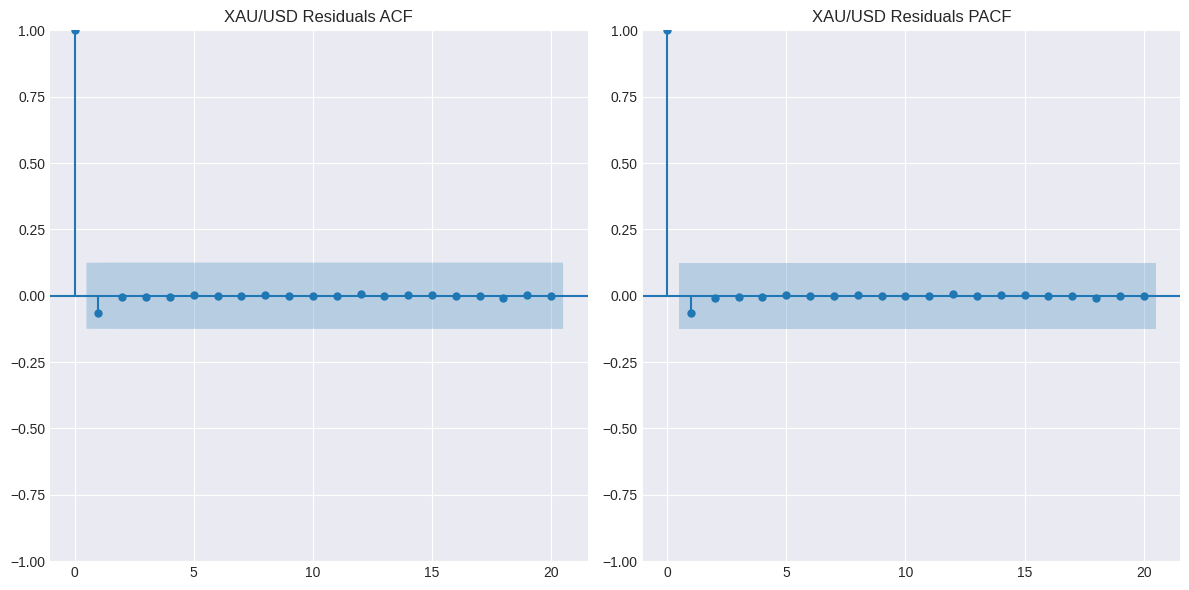


--- ACF/PACF Residuals untuk BTC/USD ---


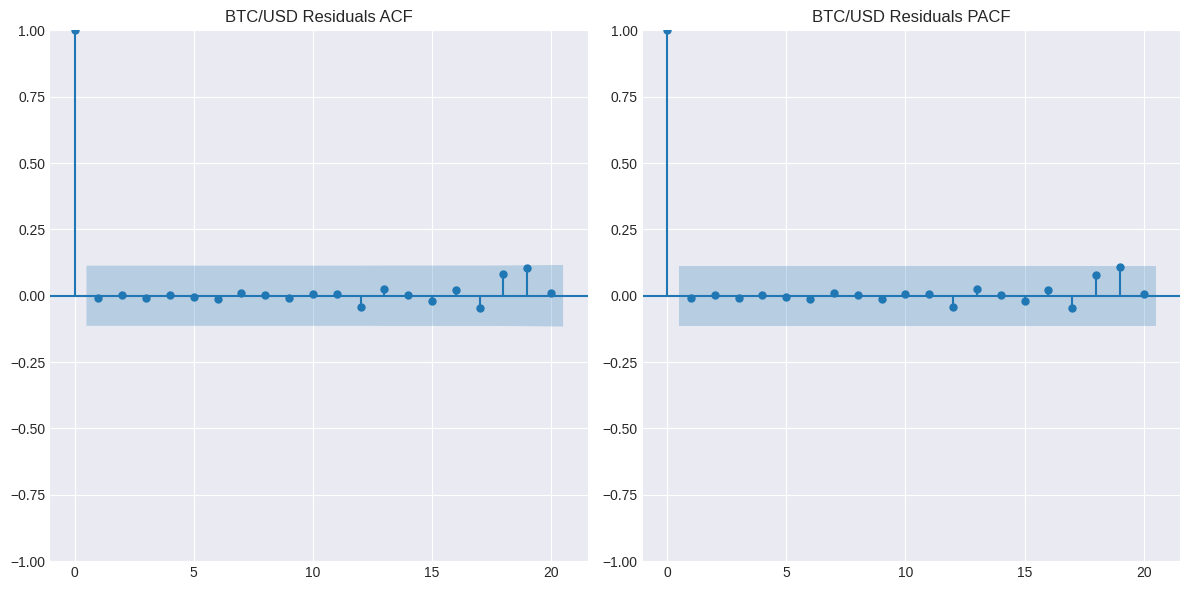


✅ Plotting residual ACF/PACF selesai.


In [329]:
# ============================================================
# 📉 Plot ACF dan PACF Residual Model
# ============================================================

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pairs_to_plot_residuals = ["XAU/USD", "BTC/USD"]
max_lags_acf_pacf = 20 # Sesuaikan jumlah lag yang ingin ditampilkan

print("\n📊 Memplot ACF dan PACF residual model...")

for pair_name in pairs_to_plot_residuals:
    if pair_name in fitted_models:
        model_result = fitted_models[pair_name]
        if model_result and model_result["fitted_model"] is not None:
            residuals = model_result["fitted_model"].resid
            print(f"\n--- ACF/PACF Residuals untuk {pair_name} ---")

            plt.figure(figsize=(12, 6))
            plot_acf(residuals, lags=max_lags_acf_pacf, ax=plt.subplot(121), title=f'{pair_name} Residuals ACF')
            plot_pacf(residuals, lags=max_lags_acf_pacf, ax=plt.subplot(122), title=f'{pair_name} Residuals PACF')
            plt.tight_layout()
            plt.show()
        else:
            print(f"⚠️ Model terpasang tidak tersedia untuk {pair_name}.")
    else:
        print(f"⚠️ Model untuk {pair_name} tidak ditemukan dalam fitted_models.")

print("\n✅ Plotting residual ACF/PACF selesai.")

In [330]:
# cell_id: 03e254fa
def plot_macro_granger_results(macro_granger_df):
    """Plot bar chart of Macro -> Pair Granger causality p-values."""
    if macro_granger_df.empty:
        print("Tidak ada hasil Granger Macro -> Pair untuk diplot.")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(data=macro_granger_df, x="Pair", y="PValue", hue="Cause", dodge=True)
    plt.title("Signifikan Granger Causality (Macro → Pair)")
    plt.ylabel("P-value")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [331]:
# cell_id: varx_predictions
# ============================================================
# 📈 Membuat Prediksi dengan Model ARX / VARX (Versi Stabil)
# ============================================================

print("\n📈 Membuat prediksi dengan model ARX/VARX untuk XAU/USD dan BTC/USD...")

predictions_from_model = {}
pairs_to_predict = ["XAU/USD", "BTC/USD"]

# Declare fitted_models as a global variable to access it from the previous cell
global fitted_models

for pair_name in pairs_to_predict:
    print(f"\n🔹 Memproses prediksi untuk {pair_name}...")

    if pair_name not in fitted_models:
        print(f"⚠️ Model untuk {pair_name} tidak ditemukan dalam fitted_models.")
        predictions_from_model[pair_name] = "Model tidak ditemukan."
        continue

    model_result = fitted_models[pair_name]
    fitted_model = model_result.get("fitted_model")

    if fitted_model is None:
        print(f"⚠️ Model terpasang tidak tersedia untuk {pair_name}.")
        predictions_from_model[pair_name] = "Model tidak terpasang."
        continue

    try:
        # --- Dapatkan exog names dari model
        exog_names = getattr(fitted_model, "exog_names", [])
        exog_required = bool(exog_names and any(name != "const" for name in exog_names))

        # --- Unduh data terbaru
        latest_pair_df = download_base_symbol(PAIRS[pair_name], lookback_days, base_interval)
        if latest_pair_df is None or latest_pair_df.empty or "Close" not in latest_pair_df.columns:
            print(f"⚠️ Data terbaru tidak valid untuk {pair_name}.")
            predictions_from_model[pair_name] = "Data terbaru tidak tersedia."
            continue

        last_historical_timestamp = latest_pair_df.index[-1]

        # --- Cek apakah data FRED sudah update ---
        # Make a copy to avoid modifying the original fred_df outside this loop iteration
        current_fred_df = fred_df.copy()
        if current_fred_df is not None and not current_fred_df.empty:

            # Pastikan index FRED bertipe datetime dan timezone-aware
            try:
                if not isinstance(current_fred_df.index, pd.DatetimeIndex):
                    current_fred_df.index = pd.to_datetime(current_fred_df.index, errors="coerce")
                if current_fred_df.index.tz is None:
                    current_fred_df = current_fred_df.tz_localize("UTC")
            except Exception as e:
                print(f"⚠️ Gagal memastikan timezone FRED df untuk prediksi: {e}")
                # Continue with prediction, but acknowledge FRED data might be misaligned
                pass # Allow prediction to continue even if FRED index fixing fails


            if current_fred_df.index[-1] < last_historical_timestamp:
                print(f"⚠️ Data FRED berhenti di {current_fred_df.index[-1]}, sedangkan harga terakhir {last_historical_timestamp}.")
                print("➡️ Menggunakan nilai terakhir FRED untuk kondisi ekonomi saat ini.")
                # Reindex and forward fill up to the last historical timestamp of the pair
                # Create a date range from the earliest FRED date to the latest price date
                date_range = pd.date_range(current_fred_df.index[0], last_historical_timestamp, freq='D')
                current_fred_df = current_fred_df.reindex(date_range, method='ffill')
                # Ensure the reindexed FRED data is timezone-aware and matches the pair data's timezone
                if current_fred_df.index.tzinfo is None and latest_pair_df.index.tzinfo is not None:
                     current_fred_df = current_fred_df.tz_localize(latest_pair_df.index.tzinfo, nonexistent='shift_forward', ambiguous='NaT')
                elif current_fred_df.index.tzinfo != latest_pair_df.index.tzinfo:
                     current_fred_df = current_fred_df.tz_convert(latest_pair_df.index.tzinfo)


        # --- Hitung base interval
        try:
            diffs = np.diff(latest_pair_df.index.astype("int64")) / 1e9 / 60
            if len(diffs) > 0:
                from collections import Counter
                base_minutes = int(Counter(diffs).most_common(1)[0][0])
            else:
                base_minutes = 60
        except Exception:
            base_minutes = 60


        next_timestamp = last_historical_timestamp + pd.Timedelta(minutes=base_minutes)
        forecast_index = pd.DatetimeIndex([next_timestamp], tz=last_historical_timestamp.tzinfo)


        # --- Siapkan exog data untuk prediksi
        forecast_exog_input = None

        if exog_required:
            if current_fred_df is not None and not current_fred_df.empty:
                # Get the last available FRED data point *after* reindexing
                last_fred_values = current_fred_df.iloc[-1]
                 # Create a DataFrame for the *next* timestamp with the last FRED values
                # Need to ensure the index of forecast_exog_input matches the expected index of the forecast
                # The forecast index is one step ahead of the last historical data
                forecast_exog_input = pd.DataFrame(
                    data=[last_fred_values.values],
                    index=forecast_index, # Use the calculated forecast_index
                    columns=last_fred_values.index
                )
                # Ensure the columns match the model's expected exog names
                if not all(name in forecast_exog_input.columns for name in exog_names if name != "const"):
                     print(f"⚠️ Kolom FRED yang dibutuhkan model {pair_name} tidak ditemukan.")
                     forecast_exog_input = None # Reset to None if columns don't match
                else:
                    # Select and reorder columns to match the model's exog_names
                    required_exog_cols = [name for name in exog_names if name != "const"]
                    forecast_exog_input = forecast_exog_input[required_exog_cols]
                    print(f"ℹ️ Menggunakan exog terbaru untuk prediksi {pair_name}: {required_exog_cols}")
            # If still None → create dummy exog (fill with 0)
            if forecast_exog_input is None and exog_names:
                 # Create a dummy DataFrame with zeros for the expected exog columns
                required_exog_cols = [name for name in exog_names if name != "const"]
                if required_exog_cols:
                    forecast_exog_input = pd.DataFrame(
                        np.zeros((1, len(required_exog_cols))),
                        index=forecast_index, # Use the calculated forecast_index
                        columns=required_exog_cols
                    )
                    print(f"⚠️ Tidak ada data FRED yang relevan atau terbaru untuk {pair_name}, menggunakan dummy exog nol.")
                else:
                    # If exog_names had 'const' only or was empty, it's not really required
                    exog_required = False
                    print(f"ℹ️ Model {pair_name} sebenarnya tidak memerlukan exogenous variables.")


        # --- Prediksi aman
        # Pass exog only if required and forecast_exog_input is not None
        if exog_required and forecast_exog_input is not None:
             forecast_result = fitted_model.get_forecast(steps=1, exog=forecast_exog_input)
        elif not exog_required:
             forecast_result = fitted_model.get_forecast(steps=1) # Pure ARMA model
        else:
            print(f"⚠️ Tidak dapat menyiapkan exog data untuk prediksi {pair_name}.")
            predictions_from_model[pair_name] = "Gagal menyiapkan data exog untuk prediksi."
            continue


        predicted_mean = forecast_result.predicted_mean
        if isinstance(predicted_mean, pd.DataFrame):
            predicted_price = float(predicted_mean.iloc[0, 0])
        else:
            predicted_price = float(predicted_mean.iloc[0])
        prediction_timestamp = predicted_mean.index[0]

        predictions_from_model[pair_name] = {
            "Predicted_Price": predicted_price,
            "Prediction_Timestamp": prediction_timestamp
        }

        print(f"✅ Prediksi {pair_name} ({prediction_timestamp:%Y-%m-%d %H:%M}) = {predicted_price:.6f}")

    except Exception as e:
        print(f"⚠️ Gagal membuat prediksi {pair_name}: {e}")
        predictions_from_model[pair_name] = f"Error prediksi: {e}"

# --- Output akhir
print("\n📋 Hasil Prediksi:")
for pair, result in predictions_from_model.items():
    if isinstance(result, dict):
        print(f"  • {pair}: {result['Predicted_Price']:.6f} (at {result['Prediction_Timestamp']})")
    else:
        print(f"  • {pair}: {result}")

print("\n✅ Proses prediksi selesai.")


📈 Membuat prediksi dengan model ARX/VARX untuk XAU/USD dan BTC/USD...

🔹 Memproses prediksi untuk XAU/USD...
⚠️ Data FRED berhenti di 2025-10-20 00:00:00+00:00, sedangkan harga terakhir 2025-10-21 08:00:00+00:00.
➡️ Menggunakan nilai terakhir FRED untuk kondisi ekonomi saat ini.
⚠️ Gagal membuat prediksi XAU/USD: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

🔹 Memproses prediksi untuk BTC/USD...
⚠️ Data FRED berhenti di 2025-10-20 00:00:00+00:00, sedangkan harga terakhir 2025-10-21 16:00:00+00:00.
➡️ Menggunakan nilai terakhir FRED untuk kondisi ekonomi saat ini.
⚠️ Gagal membuat prediksi BTC/USD: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

📋 Hasil Prediksi:
  • XAU/USD: Error prediksi: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.
  • BTC/USD: Err

In [332]:
print("Data FRED terbaru yang digunakan untuk prediksi:")
if 'fred_df' in globals() and fred_df is not None and not fred_df.empty:
    # Tampilkan beberapa baris terakhir dari fred_df
    display(fred_df.tail())
else:
    print("Variabel 'fred_df' tidak ditemukan atau kosong.")

# Jika prediksi gagal karena exog tidak cocok, kita bisa periksa kolom yang diharapkan model
# Misalnya, jika model XAU/USD atau BTC/USD membutuhkan exog, kita bisa lihat nama kolomnya
# dari fitted_models
pairs_to_check_exog = ["XAU/USD", "BTC/USD"]
print("\nKolom exog yang diharapkan oleh model (jika ada):")
for pair_name in pairs_to_check_exog:
    if pair_name in fitted_models:
        model_result = fitted_models[pair_name]
        fitted_model = model_result.get("fitted_model")
        if fitted_model is not None:
            exog_names = getattr(fitted_model, "exog_names", [])
            required_exog_cols = [name for name in exog_names if name != "const"]
            print(f"- {pair_name}: {required_exog_cols}")
        else:
            print(f"- {pair_name}: Model tidak terpasang.")
    else:
        print(f"- {pair_name}: Model tidak ditemukan.")

Data FRED terbaru yang digunakan untuk prediksi:


,effective_until_next_release,Index Semi-Annual,Emerging Markets Corporate,Markets Corporate Plus,Financial US Emerging Markets Liquiq
release_date,,,,,
2025-10-14 00:00:00+00:00,NaT,6.87,5.46,5.10,5.04
2025-10-15 00:00:00+00:00,NaT,6.74,5.42,5.07,5.02
2025-10-16 00:00:00+00:00,NaT,6.75,5.40,5.05,4.99
2025-10-17 00:00:00+00:00,NaT,6.79,5.41,5.06,5.00
2025-10-20 00:00:00+00:00,NaT,6.73,5.39,5.04,4.99



Kolom exog yang diharapkan oleh model (jika ada):
- XAU/USD: []
- BTC/USD: []
